## 1. Cartpole 강화학습 준비

In [1]:
# import
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

### 1.1 Cartpole 시연함수

In [2]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frame(frames):a
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)

    anim.save('cartpole_DQN.mp4')  # 시연영상을 저장
    display(display_animation(anim, default_mode='loop'))

### 1.2 Constant 정의

In [5]:
#name tuple을 사용하여 Transition 정의
from collections import namedtuple

Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))

In [6]:
# 상수 정의
ENV = 'CartPole-v0'  # task
GAMMA = 0.99  # discount factor
MAX_STEPS = 200  # 1에피소드 당 최대 단계 수
NUM_EPISODES = 500  # 최대 에피소드 수

## 2. ReplayMemory

In [7]:
class ReplayMemory:

    def __init__(self, CAPACITY):
        self.capacity = CAPACITY  # 메모리의 최대 저장 건수
        self.memory = []  # 실제 transition을 저장할 변수
        self.index = 0  # 저장 위치를 가리킬 인덱스 변수

    def push(self, state, action, state_next, reward):

        if len(self.memory) < self.capacity:
            self.memory.append(None) 

        self.memory[self.index] = Transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity  

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [10]:
#!pip install --upgrade pip

    100% |################################| 1.5MB 1.1MB/s ta 0:00:01
  Found existing installation: pip 9.0.1
    Uninstalling pip-9.0.1:
      Successfully uninstalled pip-9.0.1
You are using pip version 20.3.4, however version 21.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
#!pip install torch

    100% |################################| 753.2MB 2.5kB/s eta 0:00:01 0% |                                | 5.3MB 11.7MB/s eta 0:01:04    1% |                                | 10.5MB 19.5MB/s eta 0:00:39    3% |#                               | 29.5MB 20.5MB/s eta 0:00:36    4% |#                               | 37.5MB 18.0MB/s eta 0:00:40    7% |##                              | 53.8MB 24.4MB/s eta 0:00:29    9% |##                              | 70.3MB 15.3MB/s eta 0:00:45    9% |###                             | 74.1MB 16.2MB/s eta 0:00:42    10% |###                             | 80.4MB 13.7MB/s eta 0:00:50    13% |####                            | 104.3MB 17.8MB/s eta 0:00:37    14% |####                            | 108.2MB 26.4MB/s eta 0:00:25    15% |#####                           | 118.7MB 10.3MB/s eta 0:01:02    18% |#####                           | 135.6MB 14.5MB/s eta 0:00:43    18% |#####                           | 141.0MB 16.1MB/s eta 0:00:39    19% |######          

## 3. Cartpole DQN 설계

In [11]:
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 32
CAPACITY = 10000


class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  

        self.memory = ReplayMemory(CAPACITY)

        # 신경망 구성
        self.model = nn.Sequential()
        self.model.add_module('fc1', nn.Linear(num_states, 32))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('fc2', nn.Linear(32, 32))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('fc3', nn.Linear(32, num_actions))

        print(self.model)  

        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)

    def replay(self):

        if len(self.memory) < BATCH_SIZE:
            return

        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])

        self.model.eval()

        state_action_values = self.model(state_batch).gather(1, action_batch)

        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None,
                                                    batch.next_state)))
        next_state_values = torch.zeros(BATCH_SIZE)
        next_state_values[non_final_mask] = self.model(
            non_final_next_states).max(1)[0].detach()

        expected_state_action_values = reward_batch + GAMMA * next_state_values

        self.model.train()

        loss = F.smooth_l1_loss(state_action_values,
                                expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()  # 경사를 초기화
        loss.backward()  # 역전파 계산
        self.optimizer.step()  # 결합 가중치 수정

    def decide_action(self, state, episode):
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            self.model.eval()
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)

        else:
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])  

        return action

## 4. Cartpole Agent 설계

In [12]:
class Agent:
    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)
        
    def update_q_function(self):
        self.brain.replay()

    def get_action(self, state, episode):
        action = self.brain.decide_action(state, episode)
        return action

    def memorize(self, state, action, state_next, reward):
        self.brain.memory.push(state, action, state_next, reward)

## 5. Cartpole 환경 설계

In [13]:
class Environment:

    def __init__(self):
        self.env = gym.make(ENV) 
        num_states = self.env.observation_space.shape[0]  
        num_actions = self.env.action_space.n 
        self.agent = Agent(num_states, num_actions) 

        
    def run(self):
        episode_10_list = np.zeros(10)  
        complete_episodes = 0  
        episode_final = False  
        frames = [] 

        for episode in range(NUM_EPISODES):  
            observation = self.env.reset()  # 환경 초기화

            state = observation 
            state = torch.from_numpy(state).type(
                torch.FloatTensor) 
            state = torch.unsqueeze(state, 0) 

            for step in range(MAX_STEPS): 

                if episode_final is True: 
                    frames.append(self.env.render(mode='rgb_array'))

                action = self.agent.get_action(state, episode)  

                observation_next, _, done, _ = self.env.step(
                    action.item()) 

                if done:  
                    state_next = None  

                    episode_10_list = np.hstack(
                        (episode_10_list[1:], step + 1))

                    if step < 195:
                        reward = torch.FloatTensor(
                            [-1.0])  
                        complete_episodes = 0 
                    else:
                        reward = torch.FloatTensor([1.0])  
                        complete_episodes = complete_episodes + 1 
                else:
                    reward = torch.FloatTensor([0.0]) 
                    state_next = observation_next  
                    state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor) 
                    state_next = torch.unsqueeze(state_next, 0)  

                self.agent.memorize(state, action, state_next, reward)

                self.agent.update_q_function()

                state = state_next

                if done:
                    print('%d Episode: Finished after %d steps：최근 10 에피소드의 평균 단계 수 = %.1lf' % (
                        episode, step + 1, episode_10_list.mean()))
                    break

            if episode_final is True:
                display_frame(frames)
                break

            if complete_episodes >= 10:
                print('----- 10 episode success -----')
                episode_final = True

## 6. Cartpole DQN 학습

Sequential(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 9 steps：최근 10 에피소드의 평균 단계 수 = 0.9
1 Episode: Finished after 10 steps：최근 10 에피소드의 평균 단계 수 = 1.9
2 Episode: Finished after 9 steps：최근 10 에피소드의 평균 단계 수 = 2.8
3 Episode: Finished after 10 steps：최근 10 에피소드의 평균 단계 수 = 3.8
4 Episode: Finished after 14 steps：최근 10 에피소드의 평균 단계 수 = 5.2
5 Episode: Finished after 9 steps：최근 10 에피소드의 평균 단계 수 = 6.1
6 Episode: Finished after 9 steps：최근 10 에피소드의 평균 단계 수 = 7.0
7 Episode: Finished after 20 steps：최근 10 에피소드의 평균 단계 수 = 9.0
8 Episode: Finished after 26 steps：최근 10 에피소드의 평균 단계 수 = 11.6
9 Episode: Finished after 16 steps：최근 10 에피소드의 평균 단계 수 = 13.2


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

10 Episode: Finished after 16 steps：최근 10 에피소드의 평균 단계 수 = 13.9
11 Episode: Finished after 20 steps：최근 10 에피소드의 평균 단계 수 = 14.9
12 Episode: Finished after 20 steps：최근 10 에피소드의 평균 단계 수 = 16.0
13 Episode: Finished after 20 steps：최근 10 에피소드의 평균 단계 수 = 17.0
14 Episode: Finished after 33 steps：최근 10 에피소드의 평균 단계 수 = 18.9


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

15 Episode: Finished after 36 steps：최근 10 에피소드의 평균 단계 수 = 21.6
16 Episode: Finished after 27 steps：최근 10 에피소드의 평균 단계 수 = 23.4
17 Episode: Finished after 22 steps：최근 10 에피소드의 평균 단계 수 = 23.6
18 Episode: Finished after 17 steps：최근 10 에피소드의 평균 단계 수 = 22.7
19 Episode: Finished after 23 steps：최근 10 에피소드의 평균 단계 수 = 23.4


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

20 Episode: Finished after 43 steps：최근 10 에피소드의 평균 단계 수 = 26.1
21 Episode: Finished after 26 steps：최근 10 에피소드의 평균 단계 수 = 26.7
22 Episode: Finished after 37 steps：최근 10 에피소드의 평균 단계 수 = 28.4


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

23 Episode: Finished after 38 steps：최근 10 에피소드의 평균 단계 수 = 30.2
24 Episode: Finished after 32 steps：최근 10 에피소드의 평균 단계 수 = 30.1
25 Episode: Finished after 25 steps：최근 10 에피소드의 평균 단계 수 = 29.0


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

26 Episode: Finished after 44 steps：최근 10 에피소드의 평균 단계 수 = 30.7
27 Episode: Finished after 42 steps：최근 10 에피소드의 평균 단계 수 = 32.7
28 Episode: Finished after 24 steps：최근 10 에피소드의 평균 단계 수 = 33.4
29 Episode: Finished after 30 steps：최근 10 에피소드의 평균 단계 수 = 34.1


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

30 Episode: Finished after 32 steps：최근 10 에피소드의 평균 단계 수 = 33.0
31 Episode: Finished after 35 steps：최근 10 에피소드의 평균 단계 수 = 33.9
32 Episode: Finished after 40 steps：최근 10 에피소드의 평균 단계 수 = 34.2


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

33 Episode: Finished after 81 steps：최근 10 에피소드의 평균 단계 수 = 38.5
34 Episode: Finished after 82 steps：최근 10 에피소드의 평균 단계 수 = 43.5


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

35 Episode: Finished after 123 steps：최근 10 에피소드의 평균 단계 수 = 53.3
36 Episode: Finished after 65 steps：최근 10 에피소드의 평균 단계 수 = 55.4


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

37 Episode: Finished after 49 steps：최근 10 에피소드의 평균 단계 수 = 56.1
38 Episode: Finished after 88 steps：최근 10 에피소드의 평균 단계 수 = 62.5


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

39 Episode: Finished after 56 steps：최근 10 에피소드의 평균 단계 수 = 65.1
40 Episode: Finished after 62 steps：최근 10 에피소드의 평균 단계 수 = 68.1


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

41 Episode: Finished after 77 steps：최근 10 에피소드의 평균 단계 수 = 72.3


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

42 Episode: Finished after 185 steps：최근 10 에피소드의 평균 단계 수 = 86.8
43 Episode: Finished after 63 steps：최근 10 에피소드의 평균 단계 수 = 85.0


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

44 Episode: Finished after 65 steps：최근 10 에피소드의 평균 단계 수 = 83.3
45 Episode: Finished after 90 steps：최근 10 에피소드의 평균 단계 수 = 80.0


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

46 Episode: Finished after 71 steps：최근 10 에피소드의 평균 단계 수 = 80.6
47 Episode: Finished after 77 steps：최근 10 에피소드의 평균 단계 수 = 83.4


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

48 Episode: Finished after 85 steps：최근 10 에피소드의 평균 단계 수 = 83.1
49 Episode: Finished after 68 steps：최근 10 에피소드의 평균 단계 수 = 84.3


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

50 Episode: Finished after 61 steps：최근 10 에피소드의 평균 단계 수 = 84.2


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

51 Episode: Finished after 116 steps：최근 10 에피소드의 평균 단계 수 = 88.1
52 Episode: Finished after 50 steps：최근 10 에피소드의 평균 단계 수 = 74.6


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

53 Episode: Finished after 69 steps：최근 10 에피소드의 평균 단계 수 = 75.2
54 Episode: Finished after 73 steps：최근 10 에피소드의 평균 단계 수 = 76.0


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

55 Episode: Finished after 54 steps：최근 10 에피소드의 평균 단계 수 = 72.4
56 Episode: Finished after 68 steps：최근 10 에피소드의 평균 단계 수 = 72.1


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

57 Episode: Finished after 91 steps：최근 10 에피소드의 평균 단계 수 = 73.5
58 Episode: Finished after 85 steps：최근 10 에피소드의 평균 단계 수 = 73.5


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

59 Episode: Finished after 129 steps：최근 10 에피소드의 평균 단계 수 = 79.6
60 Episode: Finished after 93 steps：최근 10 에피소드의 평균 단계 수 = 82.8


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

61 Episode: Finished after 147 steps：최근 10 에피소드의 평균 단계 수 = 85.9
62 Episode: Finished after 56 steps：최근 10 에피소드의 평균 단계 수 = 86.5


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

63 Episode: Finished after 54 steps：최근 10 에피소드의 평균 단계 수 = 85.0
64 Episode: Finished after 77 steps：최근 10 에피소드의 평균 단계 수 = 85.4


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

65 Episode: Finished after 74 steps：최근 10 에피소드의 평균 단계 수 = 87.4
66 Episode: Finished after 63 steps：최근 10 에피소드의 평균 단계 수 = 86.9


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

67 Episode: Finished after 68 steps：최근 10 에피소드의 평균 단계 수 = 84.6
68 Episode: Finished after 76 steps：최근 10 에피소드의 평균 단계 수 = 83.7


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

69 Episode: Finished after 46 steps：최근 10 에피소드의 평균 단계 수 = 75.4
70 Episode: Finished after 57 steps：최근 10 에피소드의 평균 단계 수 = 71.8
71 Episode: Finished after 51 steps：최근 10 에피소드의 평균 단계 수 = 62.2


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

72 Episode: Finished after 116 steps：최근 10 에피소드의 평균 단계 수 = 68.2
73 Episode: Finished after 43 steps：최근 10 에피소드의 평균 단계 수 = 67.1


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

74 Episode: Finished after 65 steps：최근 10 에피소드의 평균 단계 수 = 65.9
75 Episode: Finished after 84 steps：최근 10 에피소드의 평균 단계 수 = 66.9


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

76 Episode: Finished after 53 steps：최근 10 에피소드의 평균 단계 수 = 65.9
77 Episode: Finished after 44 steps：최근 10 에피소드의 평균 단계 수 = 63.5
78 Episode: Finished after 49 steps：최근 10 에피소드의 평균 단계 수 = 60.8


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

79 Episode: Finished after 77 steps：최근 10 에피소드의 평균 단계 수 = 63.9
80 Episode: Finished after 73 steps：최근 10 에피소드의 평균 단계 수 = 65.5


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

81 Episode: Finished after 72 steps：최근 10 에피소드의 평균 단계 수 = 67.6
82 Episode: Finished after 96 steps：최근 10 에피소드의 평균 단계 수 = 65.6


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

83 Episode: Finished after 125 steps：최근 10 에피소드의 평균 단계 수 = 73.8


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

84 Episode: Finished after 119 steps：최근 10 에피소드의 평균 단계 수 = 79.2
85 Episode: Finished after 75 steps：최근 10 에피소드의 평균 단계 수 = 78.3


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

86 Episode: Finished after 52 steps：최근 10 에피소드의 평균 단계 수 = 78.2
87 Episode: Finished after 65 steps：최근 10 에피소드의 평균 단계 수 = 80.3


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

88 Episode: Finished after 56 steps：최근 10 에피소드의 평균 단계 수 = 81.0
89 Episode: Finished after 59 steps：최근 10 에피소드의 평균 단계 수 = 79.2


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

90 Episode: Finished after 65 steps：최근 10 에피소드의 평균 단계 수 = 78.4


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

91 Episode: Finished after 113 steps：최근 10 에피소드의 평균 단계 수 = 82.5
92 Episode: Finished after 69 steps：최근 10 에피소드의 평균 단계 수 = 79.8


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

93 Episode: Finished after 107 steps：최근 10 에피소드의 평균 단계 수 = 78.0


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

94 Episode: Finished after 129 steps：최근 10 에피소드의 평균 단계 수 = 79.0
95 Episode: Finished after 81 steps：최근 10 에피소드의 평균 단계 수 = 79.6


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

96 Episode: Finished after 114 steps：최근 10 에피소드의 평균 단계 수 = 85.8


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

97 Episode: Finished after 130 steps：최근 10 에피소드의 평균 단계 수 = 92.3


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

98 Episode: Finished after 170 steps：최근 10 에피소드의 평균 단계 수 = 103.7


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

99 Episode: Finished after 124 steps：최근 10 에피소드의 평균 단계 수 = 110.2


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

100 Episode: Finished after 101 steps：최근 10 에피소드의 평균 단계 수 = 113.8
101 Episode: Finished after 80 steps：최근 10 에피소드의 평균 단계 수 = 110.5


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

102 Episode: Finished after 84 steps：최근 10 에피소드의 평균 단계 수 = 112.0


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

103 Episode: Finished after 112 steps：최근 10 에피소드의 평균 단계 수 = 112.5


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

104 Episode: Finished after 117 steps：최근 10 에피소드의 평균 단계 수 = 111.3


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

105 Episode: Finished after 137 steps：최근 10 에피소드의 평균 단계 수 = 116.9


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

106 Episode: Finished after 126 steps：최근 10 에피소드의 평균 단계 수 = 118.1


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

107 Episode: Finished after 133 steps：최근 10 에피소드의 평균 단계 수 = 118.4
108 Episode: Finished after 91 steps：최근 10 에피소드의 평균 단계 수 = 110.5


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

109 Episode: Finished after 104 steps：최근 10 에피소드의 평균 단계 수 = 108.5


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

110 Episode: Finished after 164 steps：최근 10 에피소드의 평균 단계 수 = 114.8


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

111 Episode: Finished after 127 steps：최근 10 에피소드의 평균 단계 수 = 119.5
112 Episode: Finished after 77 steps：최근 10 에피소드의 평균 단계 수 = 118.8


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

113 Episode: Finished after 103 steps：최근 10 에피소드의 평균 단계 수 = 117.9


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

114 Episode: Finished after 122 steps：최근 10 에피소드의 평균 단계 수 = 118.4
115 Episode: Finished after 97 steps：최근 10 에피소드의 평균 단계 수 = 114.4


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

116 Episode: Finished after 117 steps：최근 10 에피소드의 평균 단계 수 = 113.5
117 Episode: Finished after 78 steps：최근 10 에피소드의 평균 단계 수 = 108.0


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

118 Episode: Finished after 97 steps：최근 10 에피소드의 평균 단계 수 = 108.6


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

119 Episode: Finished after 135 steps：최근 10 에피소드의 평균 단계 수 = 111.7
120 Episode: Finished after 64 steps：최근 10 에피소드의 평균 단계 수 = 101.7


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

121 Episode: Finished after 128 steps：최근 10 에피소드의 평균 단계 수 = 101.8


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

122 Episode: Finished after 108 steps：최근 10 에피소드의 평균 단계 수 = 104.9


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

123 Episode: Finished after 116 steps：최근 10 에피소드의 평균 단계 수 = 106.2
124 Episode: Finished after 82 steps：최근 10 에피소드의 평균 단계 수 = 102.2


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

125 Episode: Finished after 159 steps：최근 10 에피소드의 평균 단계 수 = 108.4


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

126 Episode: Finished after 189 steps：최근 10 에피소드의 평균 단계 수 = 115.6


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

127 Episode: Finished after 132 steps：최근 10 에피소드의 평균 단계 수 = 121.0


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

128 Episode: Finished after 160 steps：최근 10 에피소드의 평균 단계 수 = 127.3


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

129 Episode: Finished after 124 steps：최근 10 에피소드의 평균 단계 수 = 126.2


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

130 Episode: Finished after 184 steps：최근 10 에피소드의 평균 단계 수 = 138.2


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

131 Episode: Finished after 149 steps：최근 10 에피소드의 평균 단계 수 = 140.3


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

132 Episode: Finished after 146 steps：최근 10 에피소드의 평균 단계 수 = 144.1


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

133 Episode: Finished after 123 steps：최근 10 에피소드의 평균 단계 수 = 144.8


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

134 Episode: Finished after 177 steps：최근 10 에피소드의 평균 단계 수 = 154.3


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

135 Episode: Finished after 120 steps：최근 10 에피소드의 평균 단계 수 = 150.4


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

136 Episode: Finished after 144 steps：최근 10 에피소드의 평균 단계 수 = 145.9


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

137 Episode: Finished after 179 steps：최근 10 에피소드의 평균 단계 수 = 150.6


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

138 Episode: Finished after 127 steps：최근 10 에피소드의 평균 단계 수 = 147.3


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

139 Episode: Finished after 133 steps：최근 10 에피소드의 평균 단계 수 = 148.2


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

140 Episode: Finished after 128 steps：최근 10 에피소드의 평균 단계 수 = 142.6


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

141 Episode: Finished after 166 steps：최근 10 에피소드의 평균 단계 수 = 144.3


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

142 Episode: Finished after 130 steps：최근 10 에피소드의 평균 단계 수 = 142.7
143 Episode: Finished after 105 steps：최근 10 에피소드의 평균 단계 수 = 140.9


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

144 Episode: Finished after 99 steps：최근 10 에피소드의 평균 단계 수 = 133.1


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

145 Episode: Finished after 106 steps：최근 10 에피소드의 평균 단계 수 = 131.7
146 Episode: Finished after 95 steps：최근 10 에피소드의 평균 단계 수 = 126.8


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

147 Episode: Finished after 102 steps：최근 10 에피소드의 평균 단계 수 = 119.1
148 Episode: Finished after 92 steps：최근 10 에피소드의 평균 단계 수 = 115.6


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

149 Episode: Finished after 107 steps：최근 10 에피소드의 평균 단계 수 = 113.0
150 Episode: Finished after 106 steps：최근 10 에피소드의 평균 단계 수 = 110.8


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

151 Episode: Finished after 101 steps：최근 10 에피소드의 평균 단계 수 = 104.3


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

152 Episode: Finished after 134 steps：최근 10 에피소드의 평균 단계 수 = 104.7


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

153 Episode: Finished after 133 steps：최근 10 에피소드의 평균 단계 수 = 107.5


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

154 Episode: Finished after 161 steps：최근 10 에피소드의 평균 단계 수 = 113.7


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

155 Episode: Finished after 139 steps：최근 10 에피소드의 평균 단계 수 = 117.0


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

156 Episode: Finished after 192 steps：최근 10 에피소드의 평균 단계 수 = 126.7


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

157 Episode: Finished after 200 steps：최근 10 에피소드의 평균 단계 수 = 136.5


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

158 Episode: Finished after 200 steps：최근 10 에피소드의 평균 단계 수 = 147.3


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

159 Episode: Finished after 200 steps：최근 10 에피소드의 평균 단계 수 = 156.6


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

160 Episode: Finished after 200 steps：최근 10 에피소드의 평균 단계 수 = 166.0


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

161 Episode: Finished after 200 steps：최근 10 에피소드의 평균 단계 수 = 175.9


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

162 Episode: Finished after 200 steps：최근 10 에피소드의 평균 단계 수 = 182.5


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

163 Episode: Finished after 200 steps：최근 10 에피소드의 평균 단계 수 = 189.2


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

164 Episode: Finished after 200 steps：최근 10 에피소드의 평균 단계 수 = 193.1


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

165 Episode: Finished after 200 steps：최근 10 에피소드의 평균 단계 수 = 199.2


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

166 Episode: Finished after 200 steps：최근 10 에피소드의 평균 단계 수 = 200.0
10 에피소드 연속 성공


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

167 Episode: Finished after 200 steps：최근 10 에피소드의 평균 단계 수 = 200.0



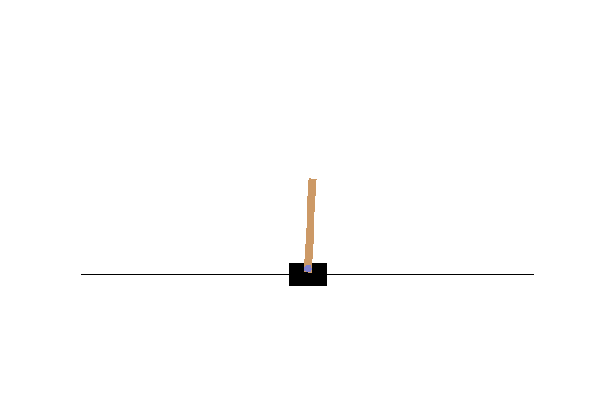
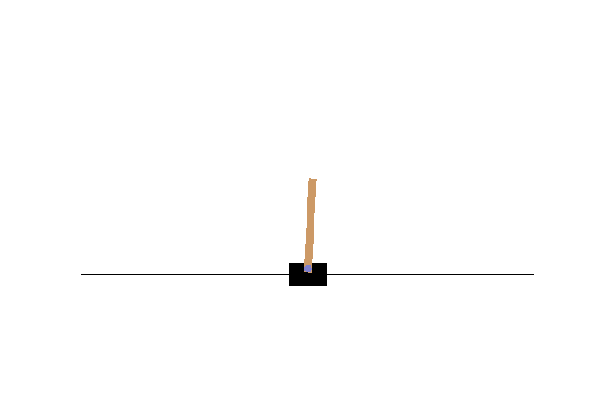
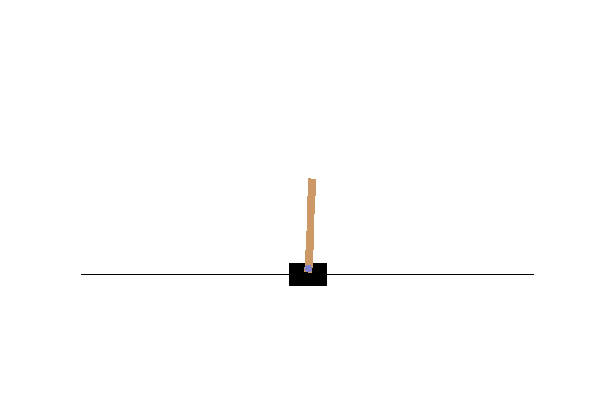
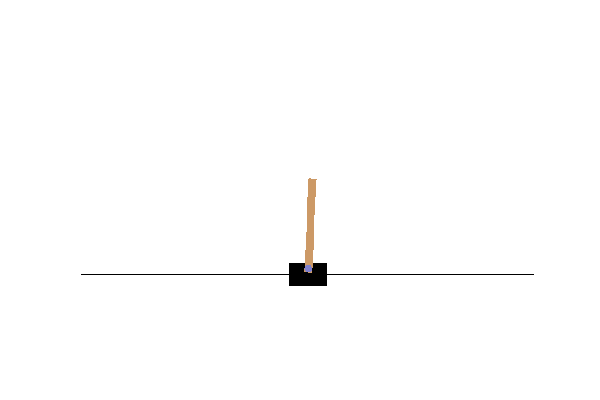
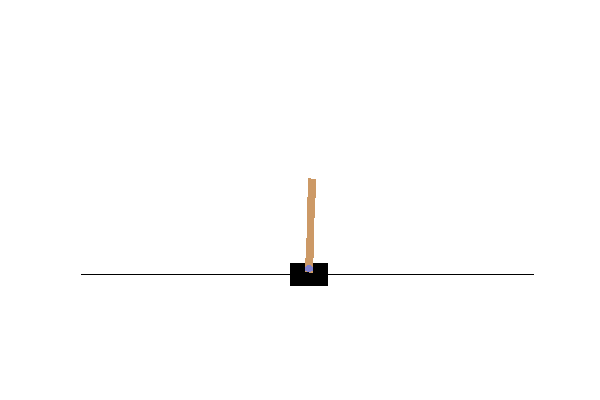
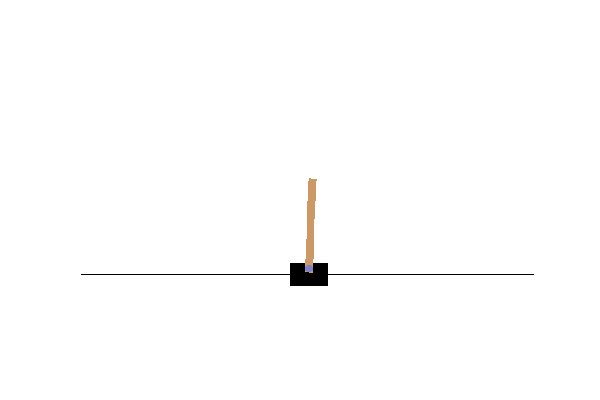
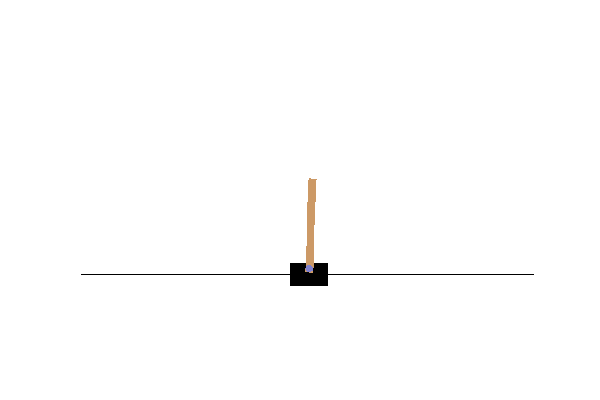
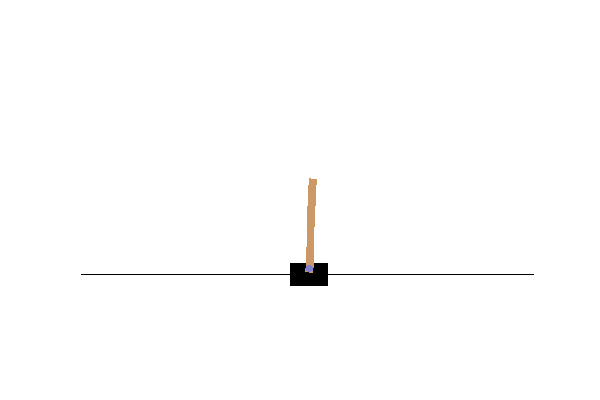
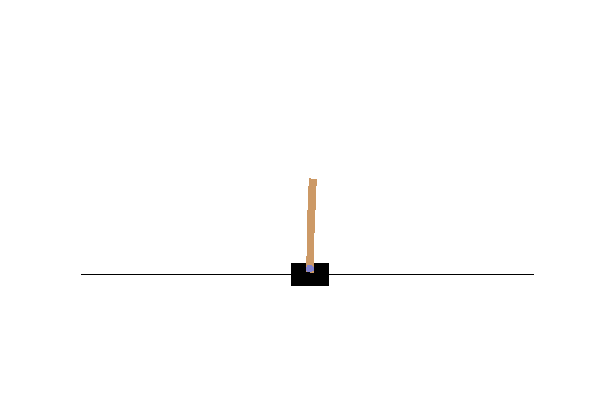
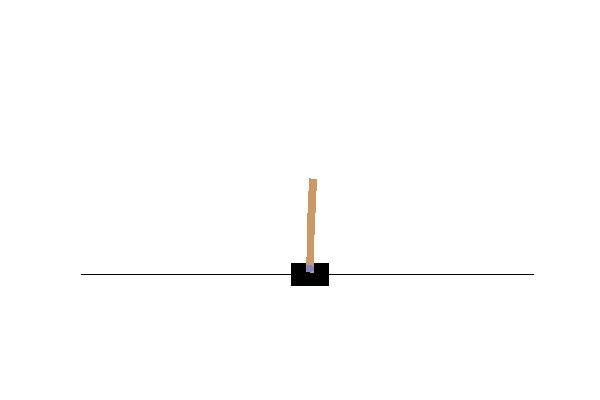
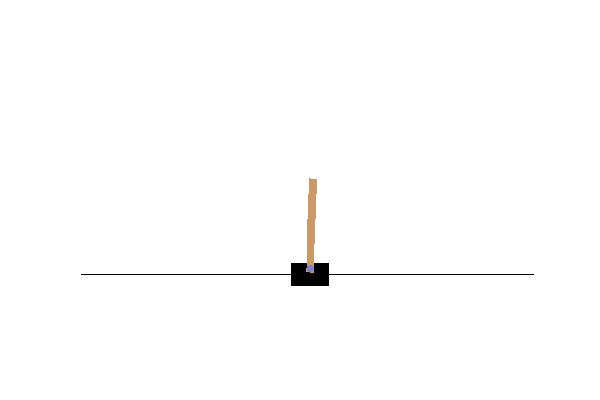
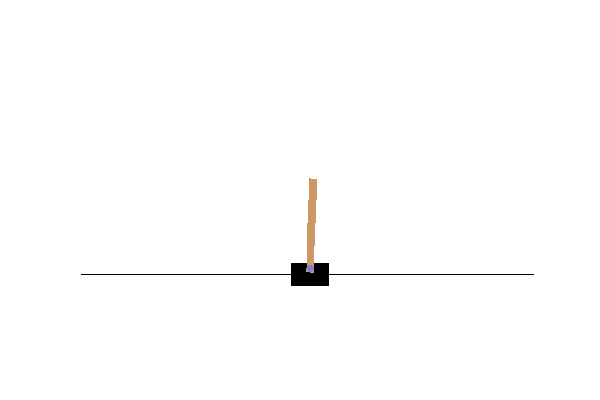
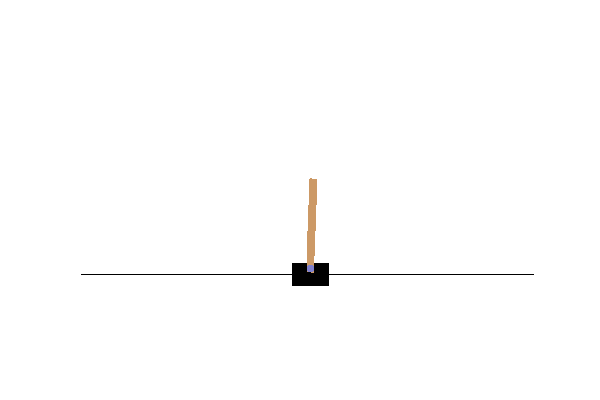
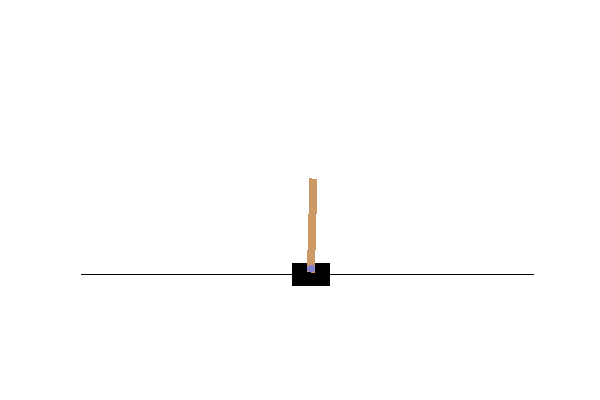
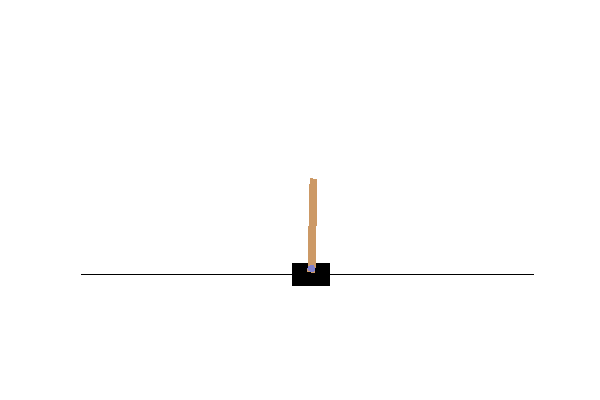
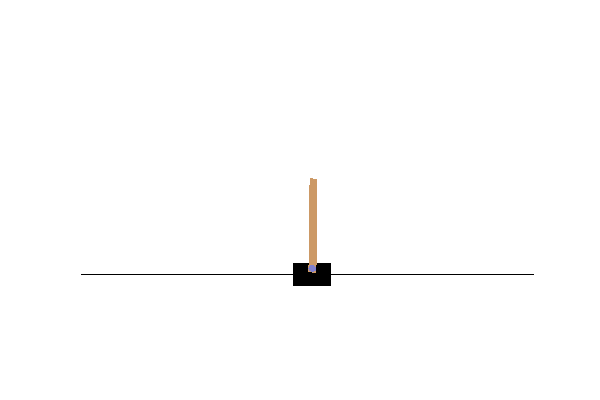
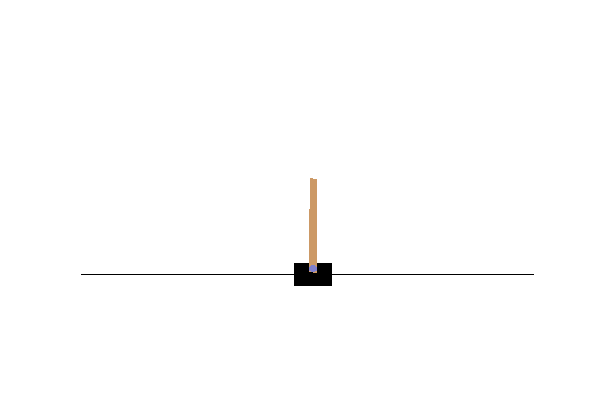
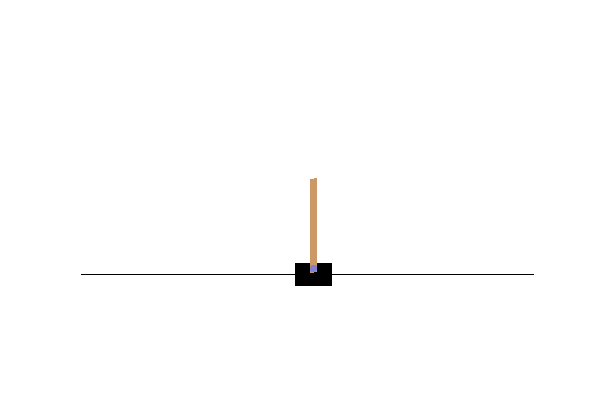
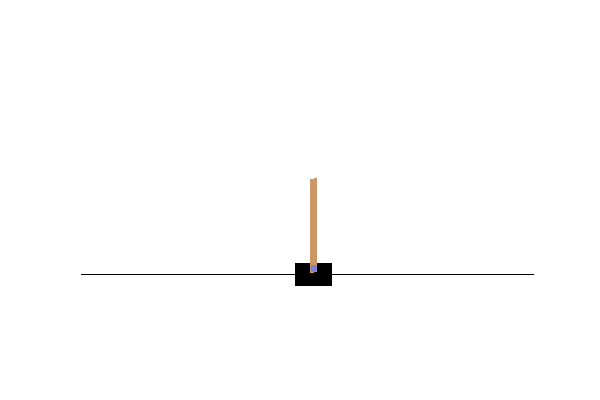
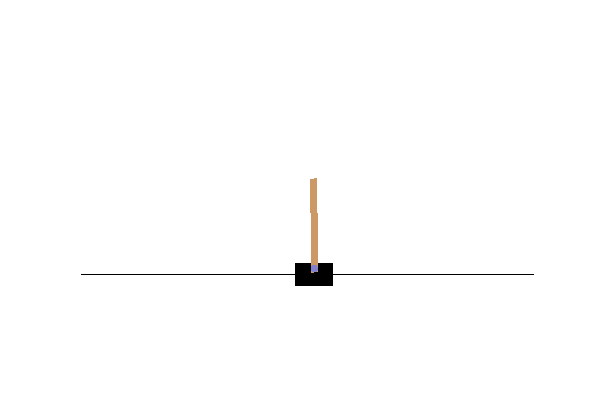
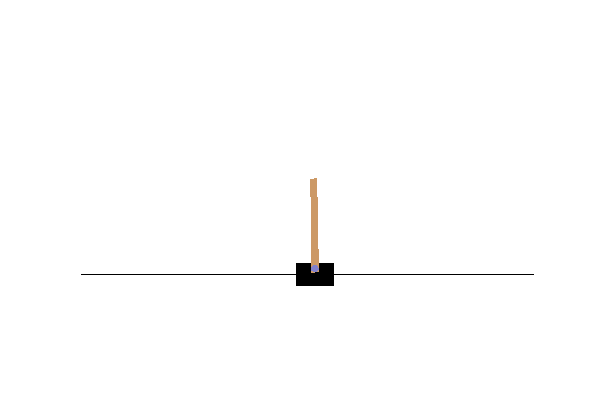
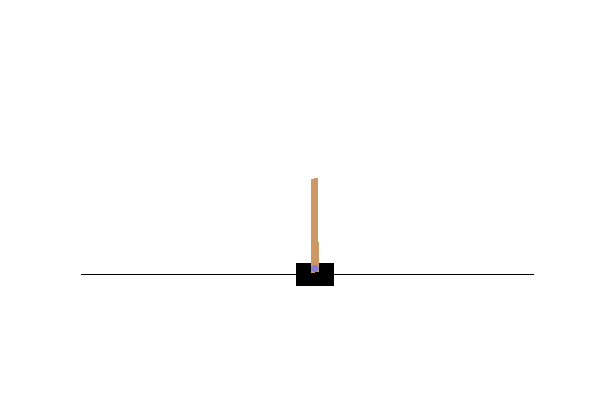
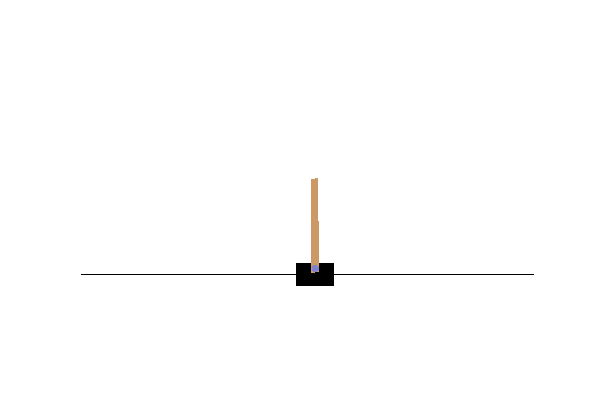
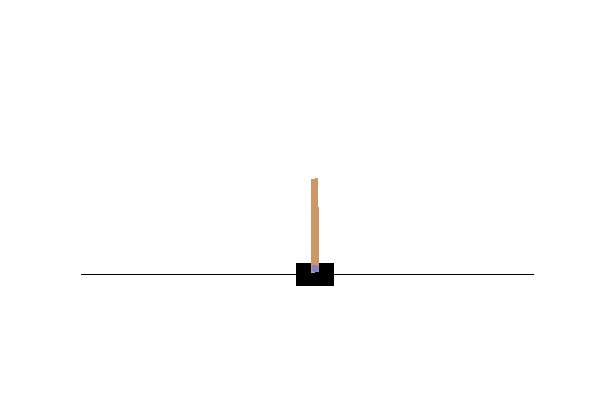
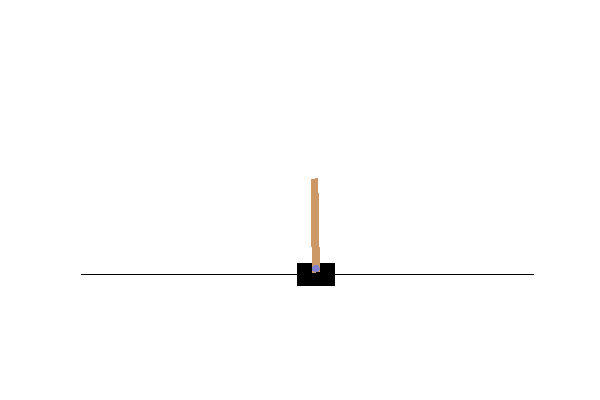
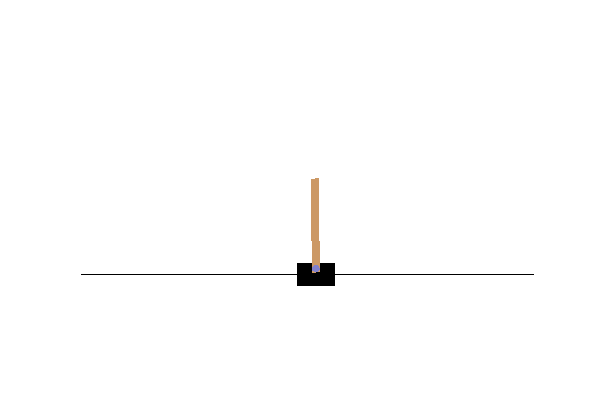
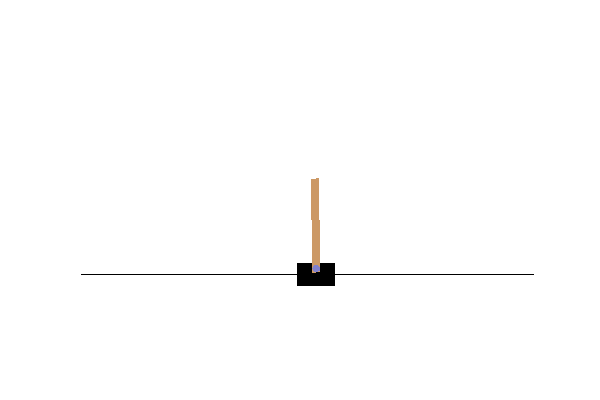
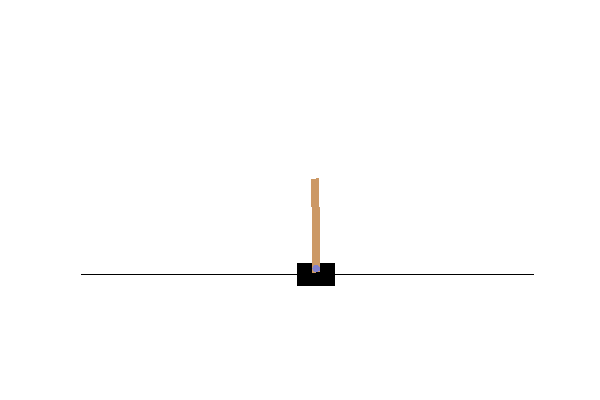
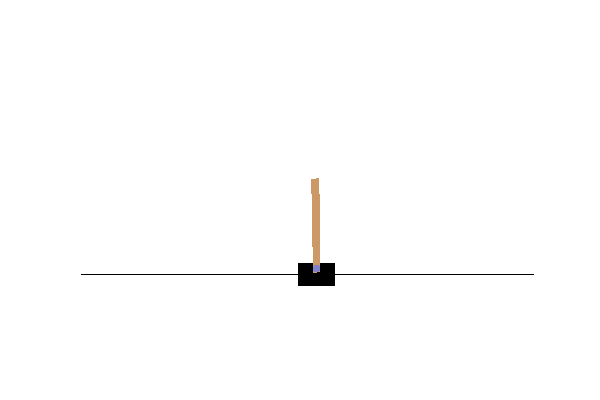
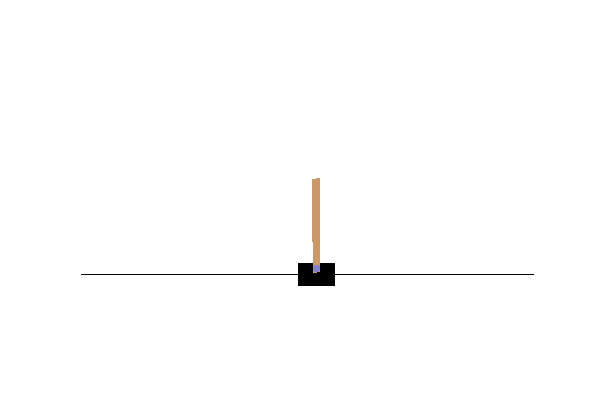
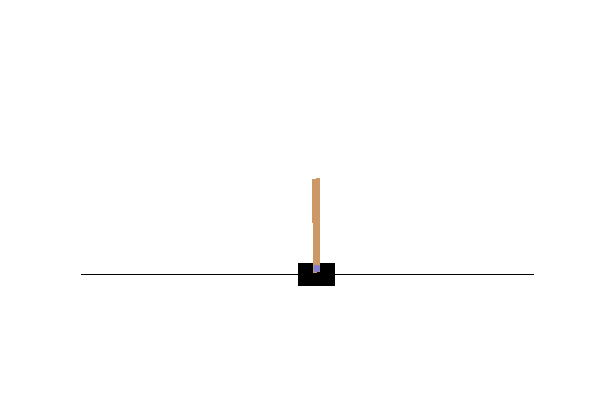
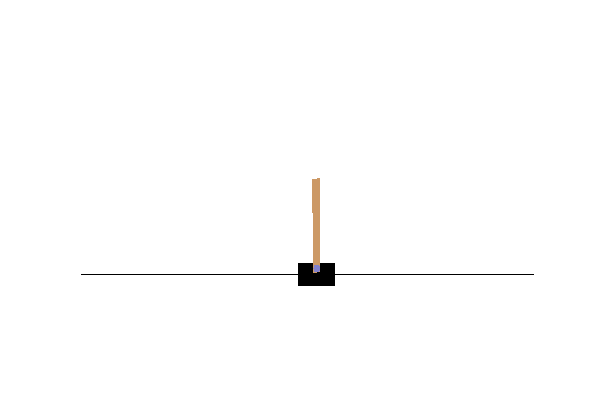
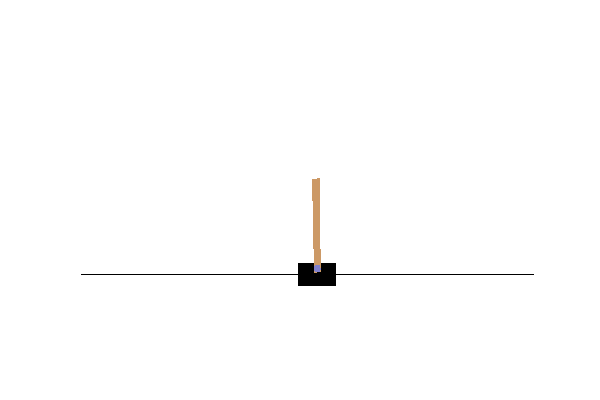
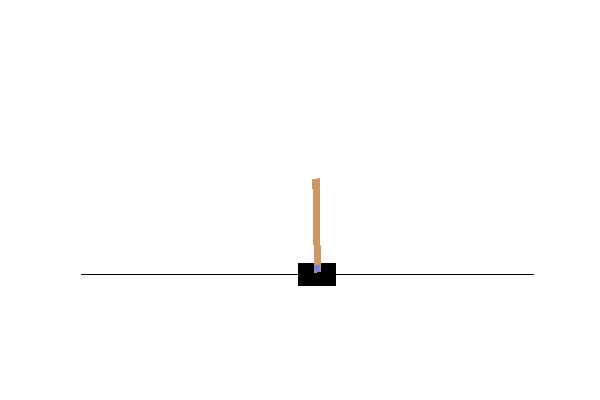
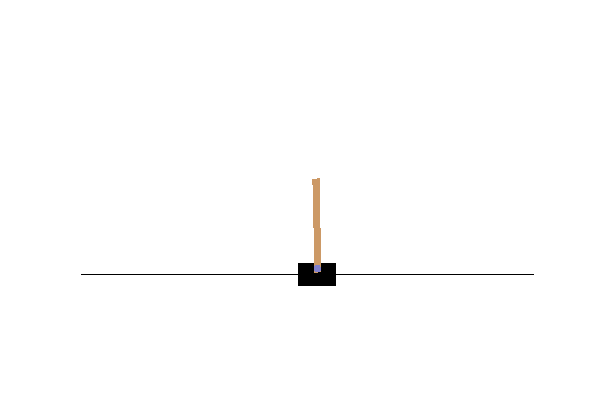
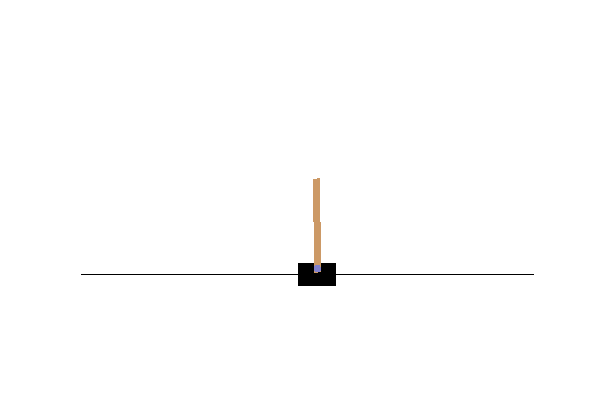
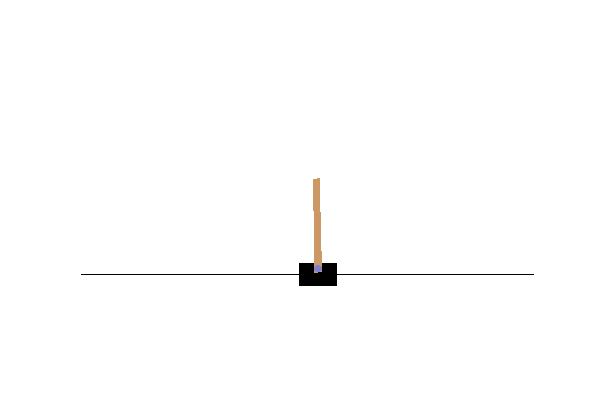
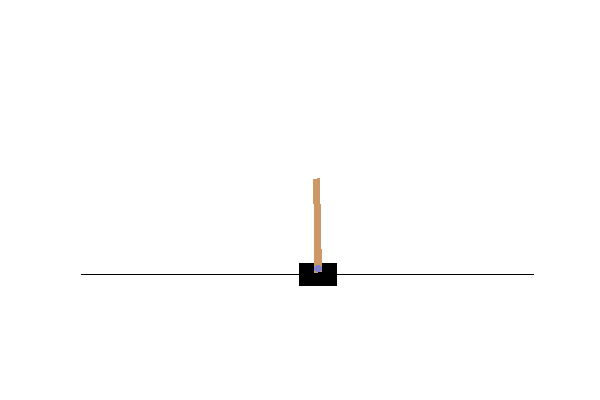
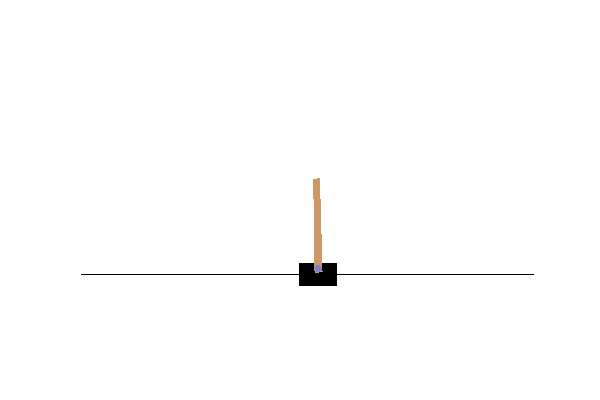
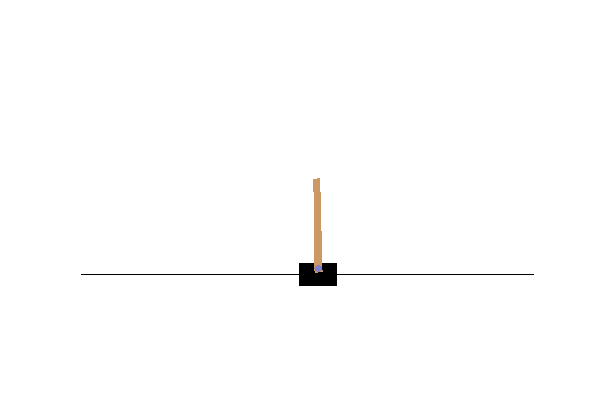
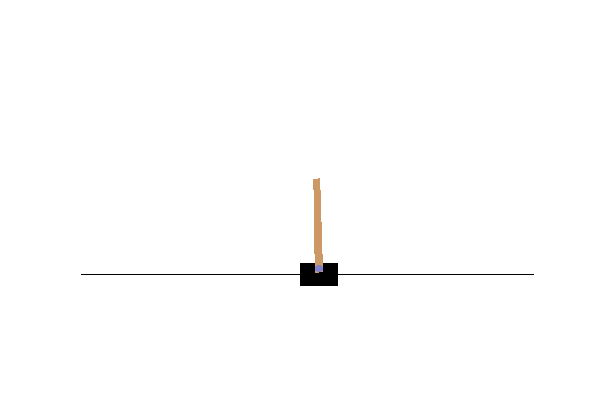
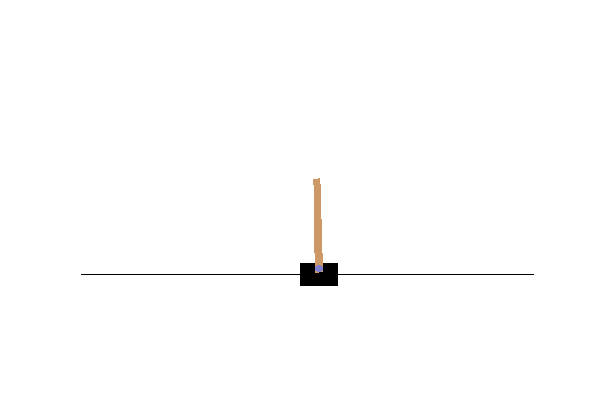
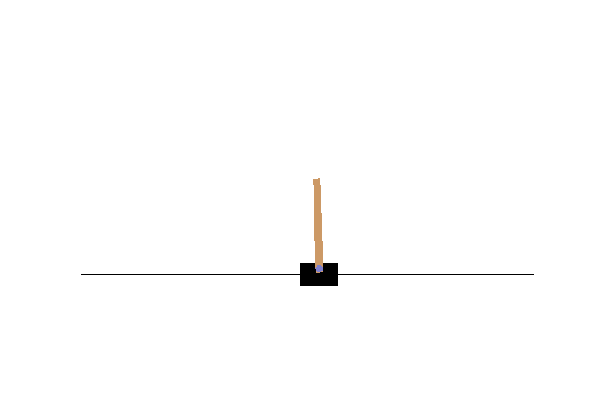
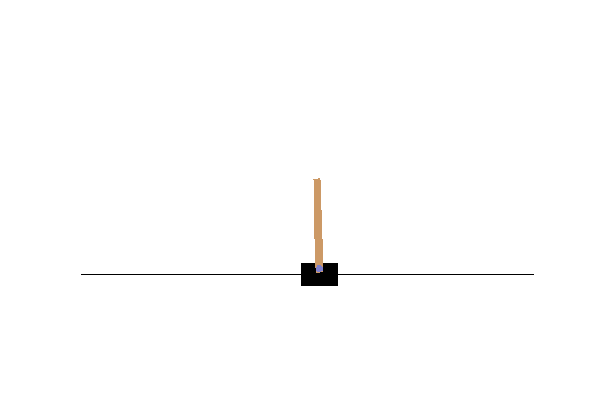
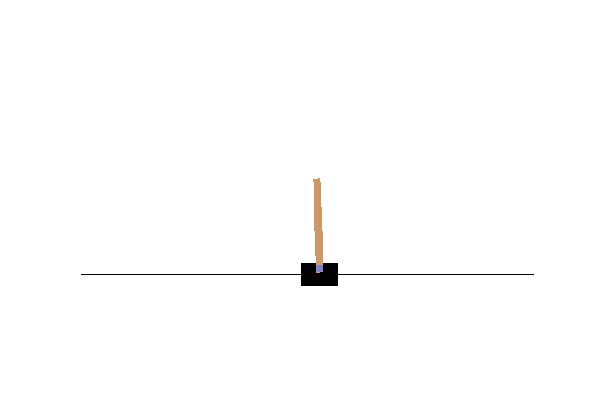
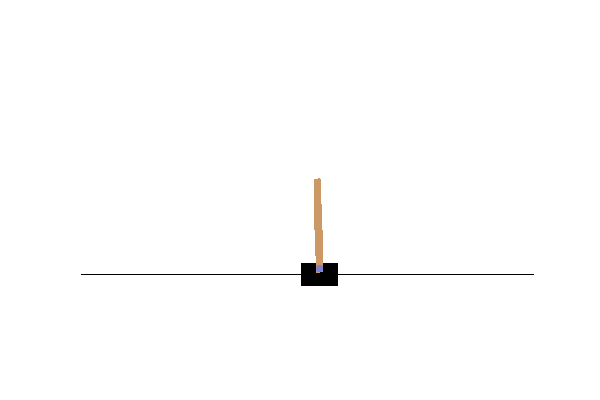
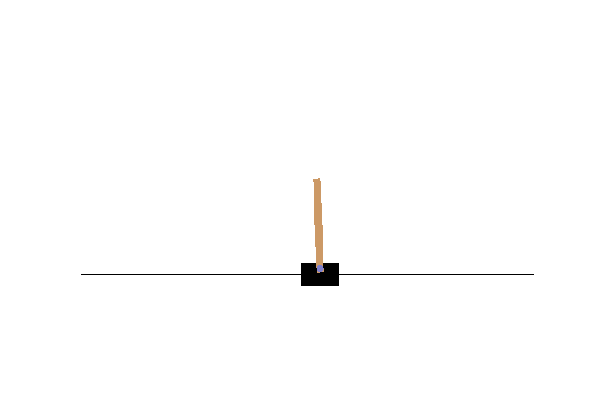
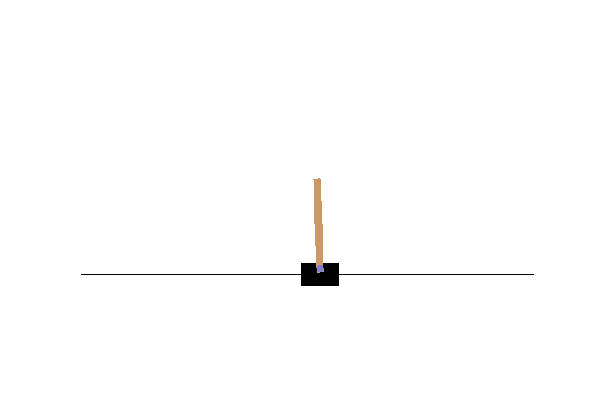
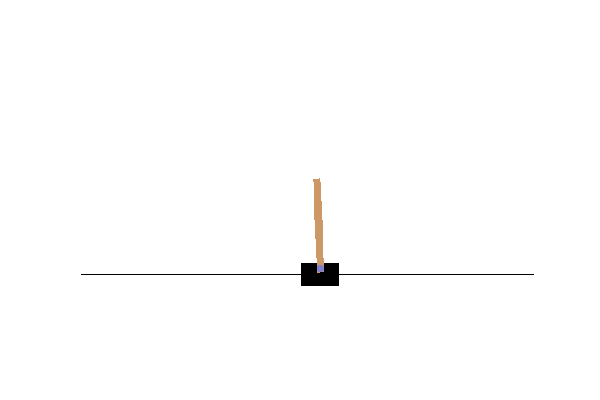
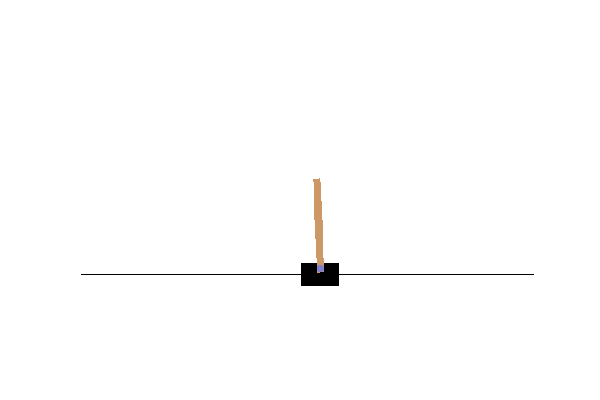
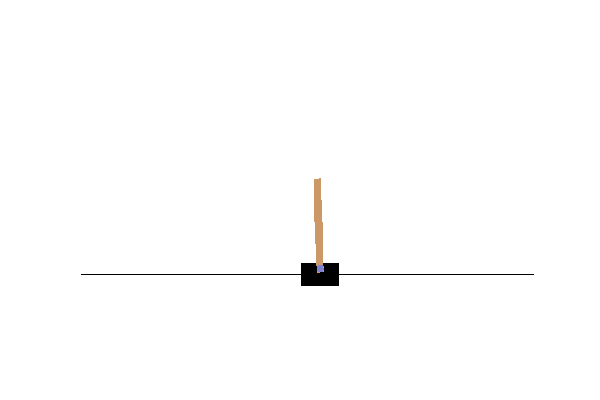
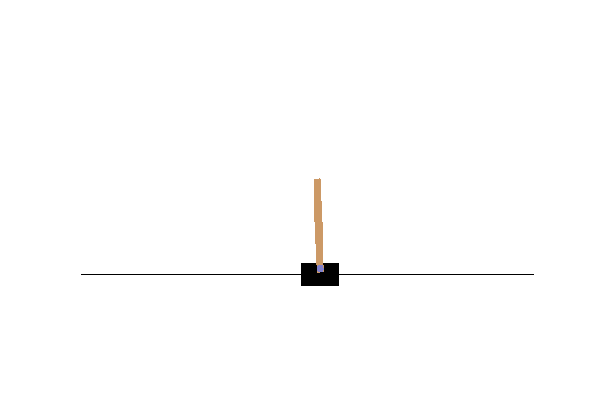
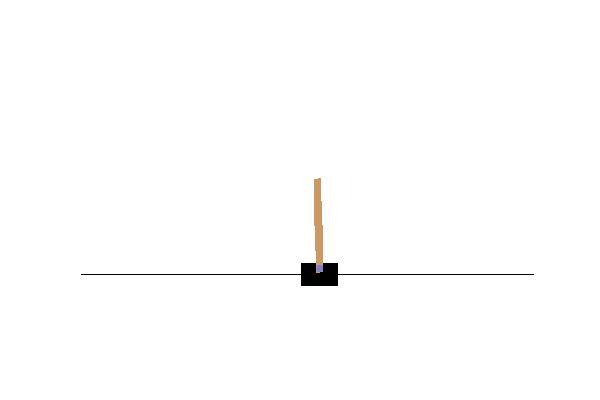
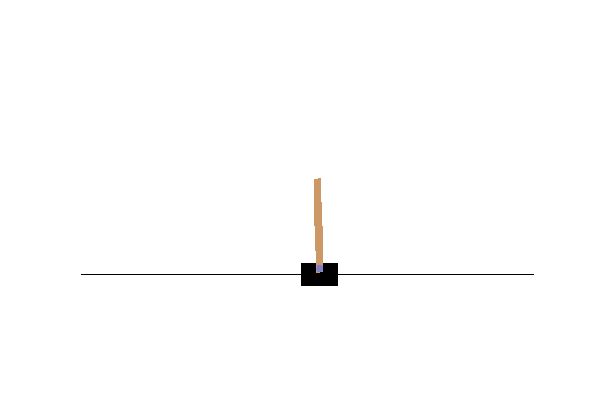
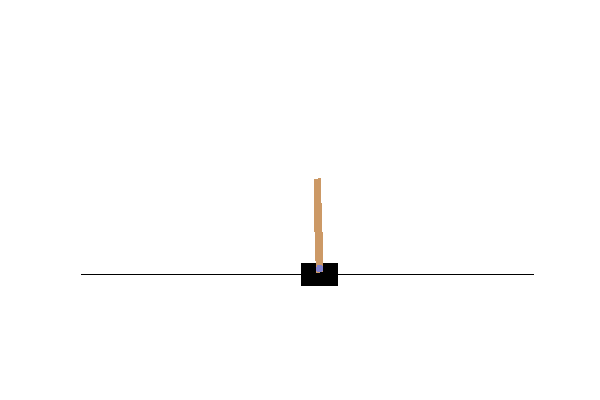
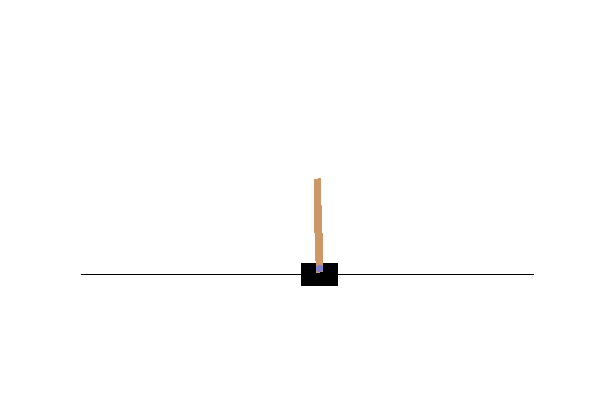
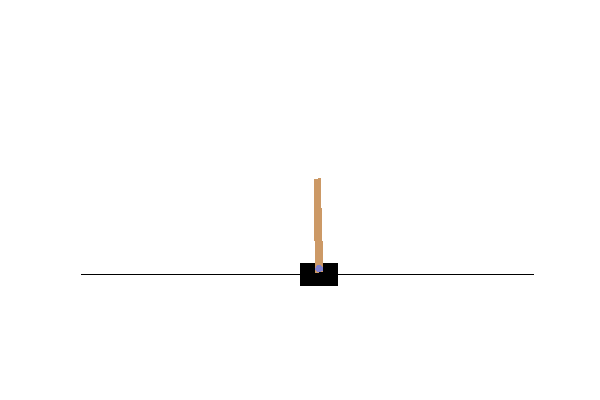
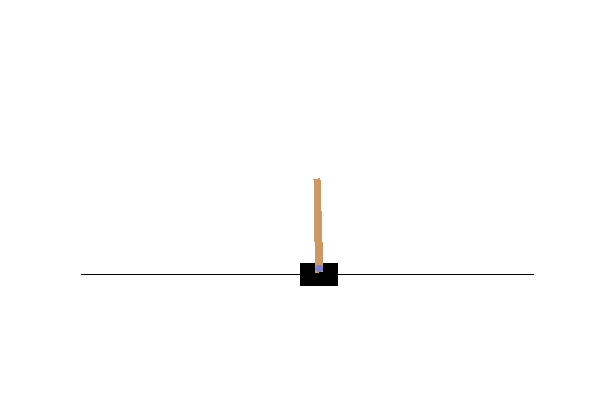
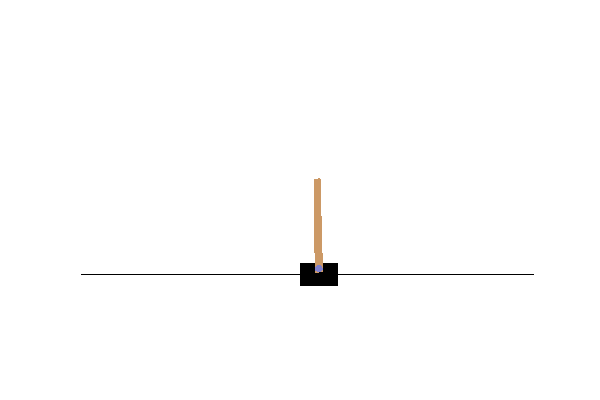
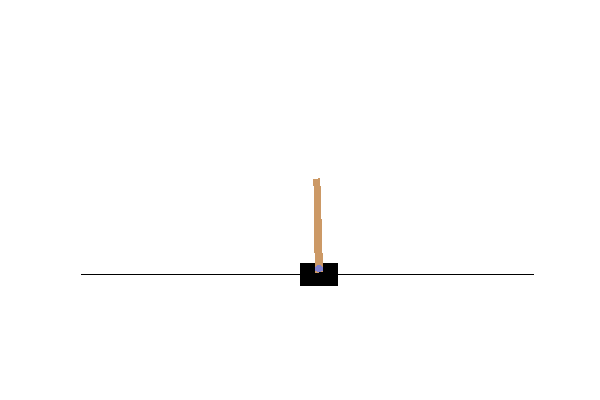
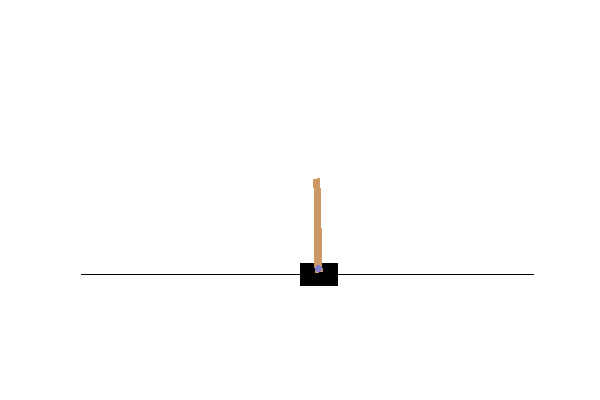
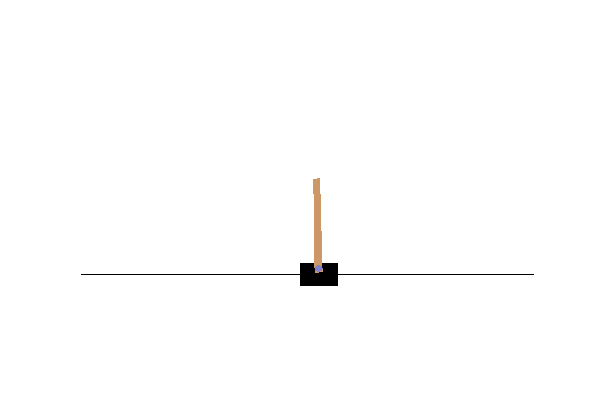
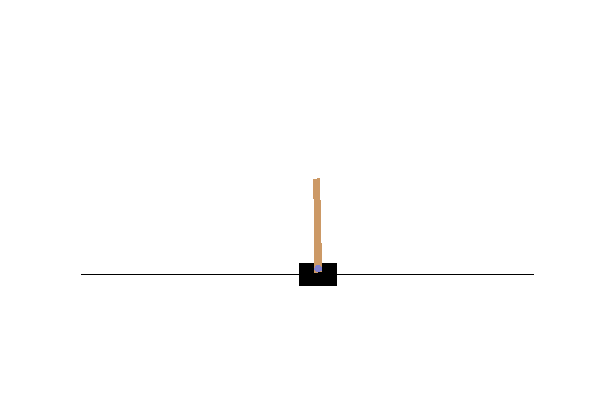
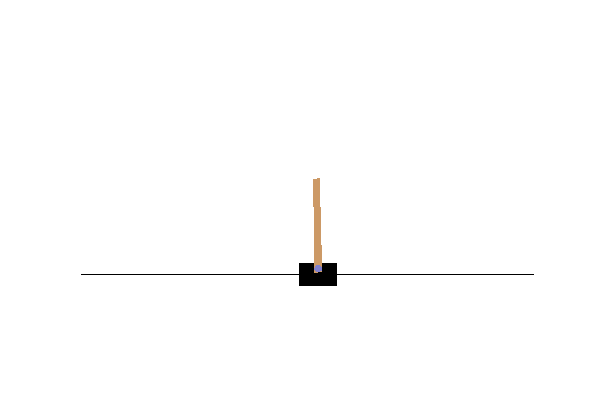
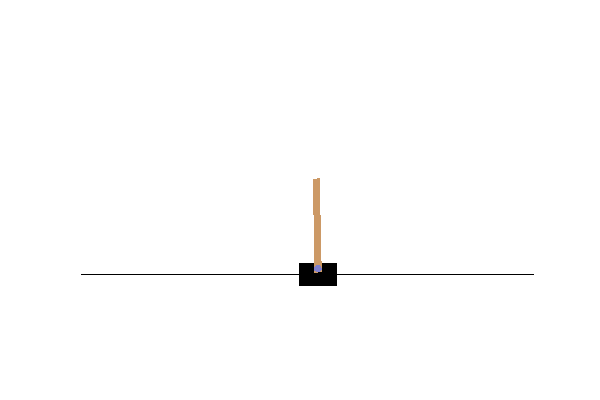
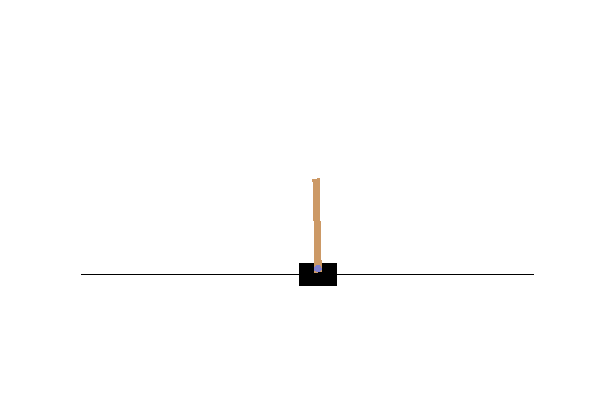
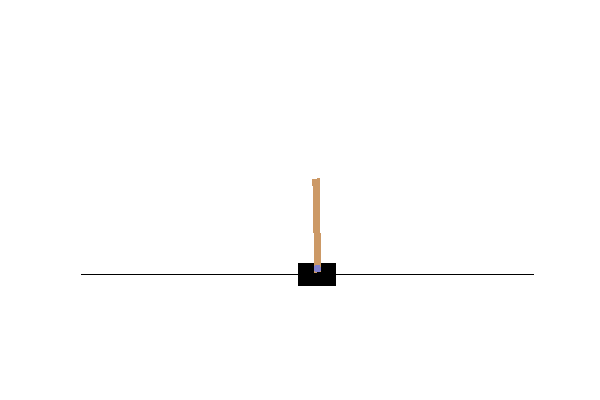
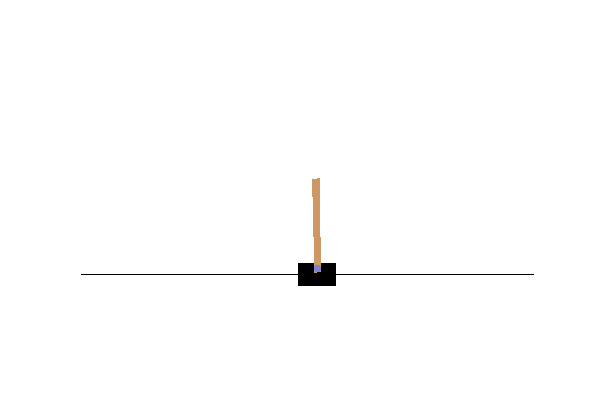
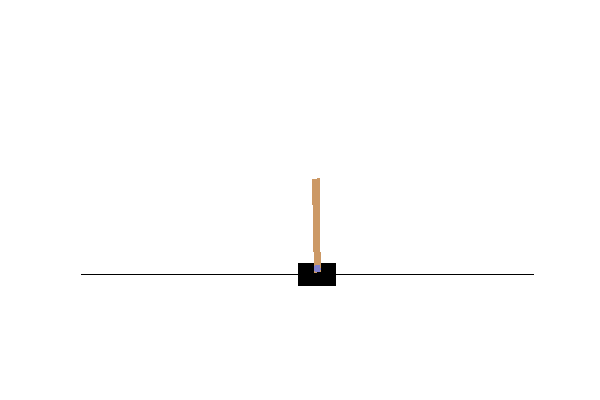
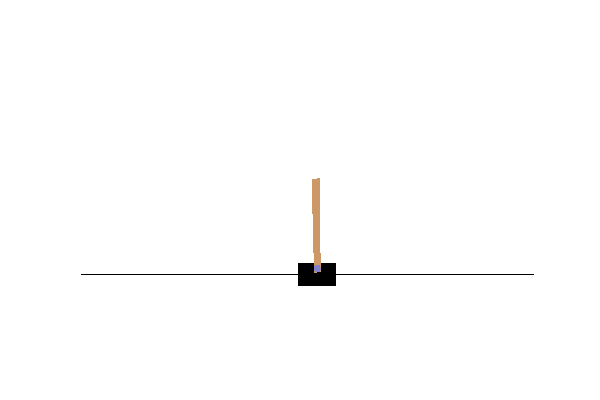
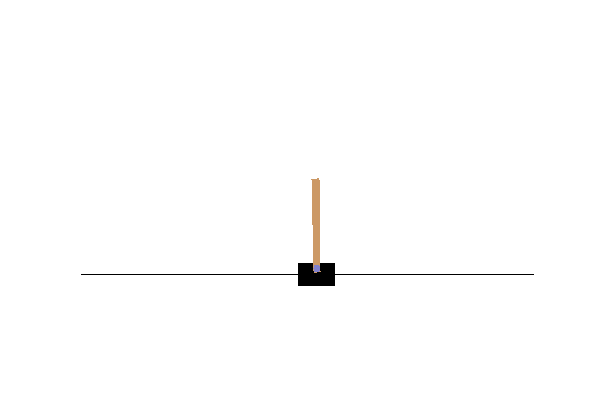
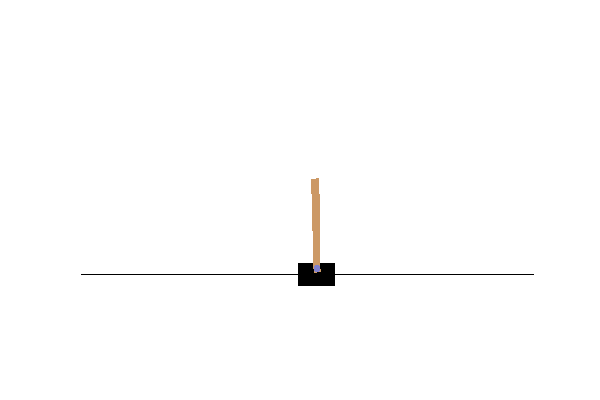
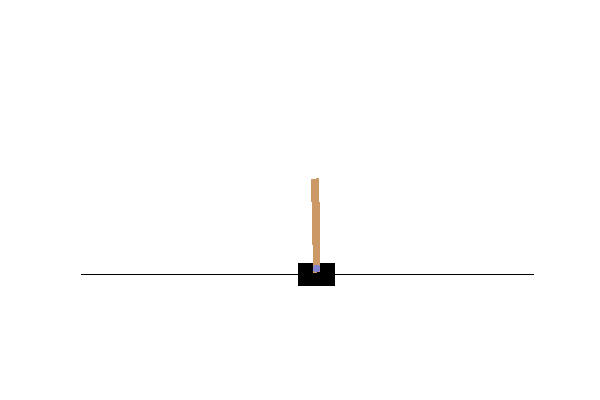
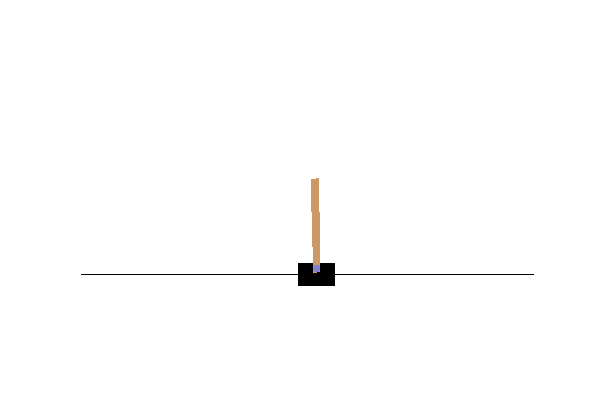
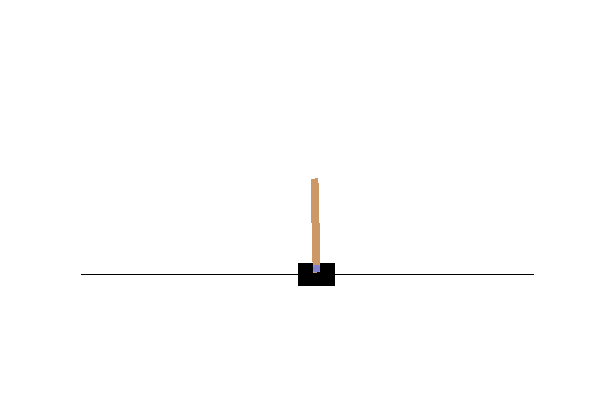
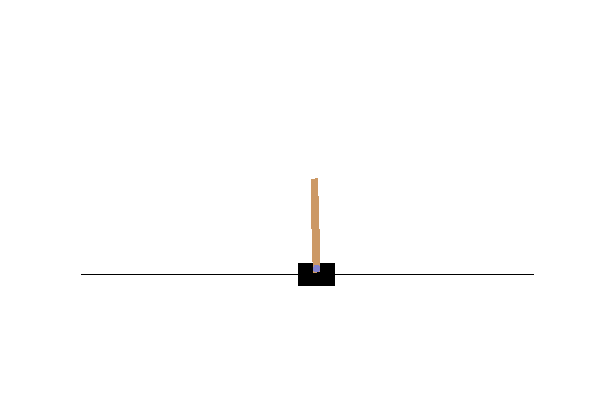
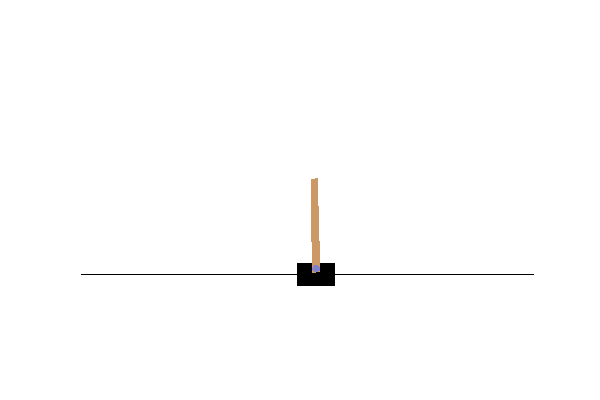
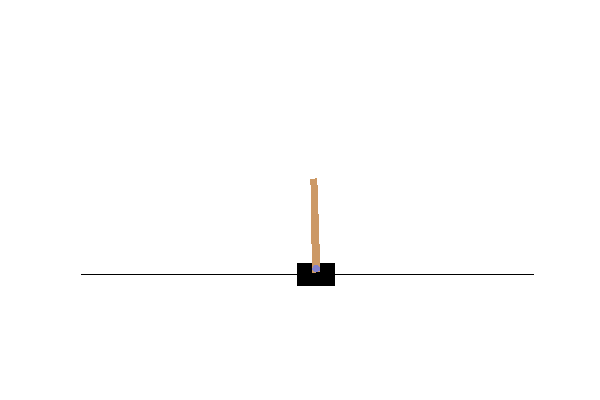
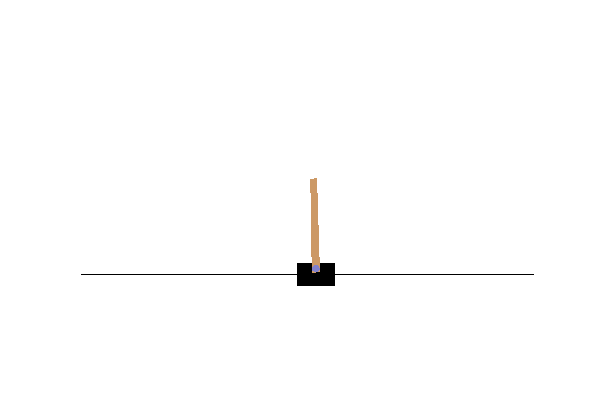
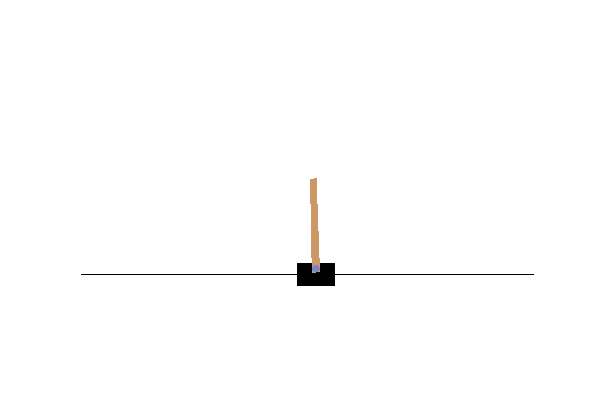
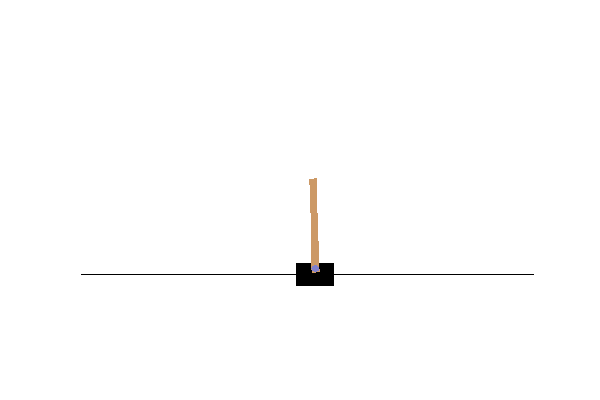
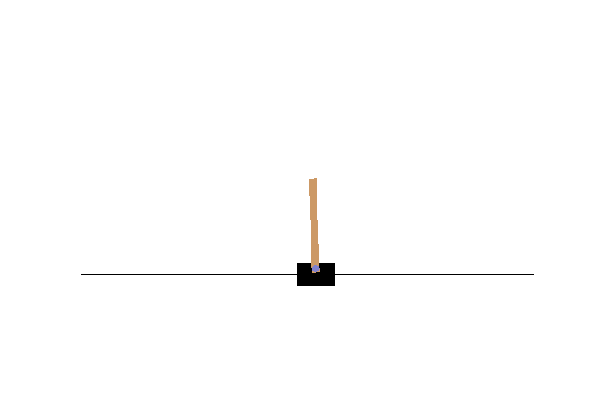
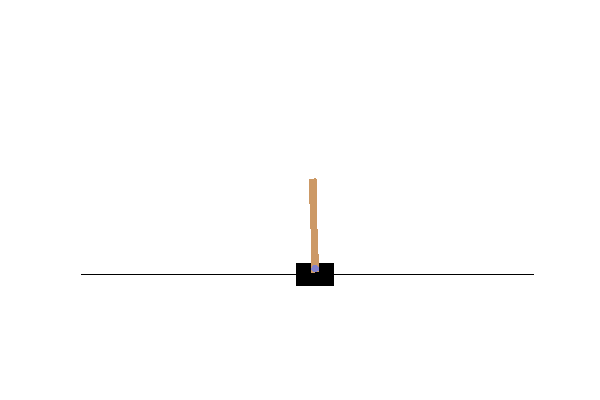
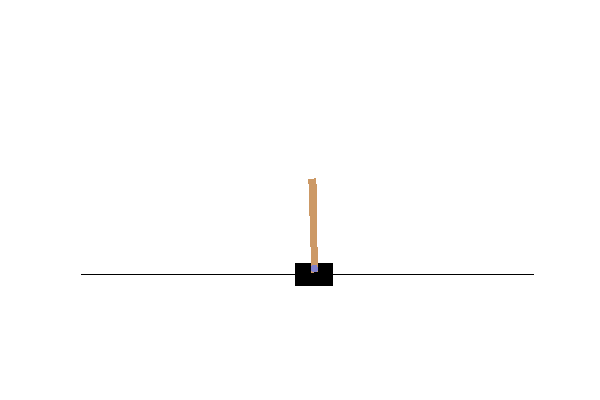
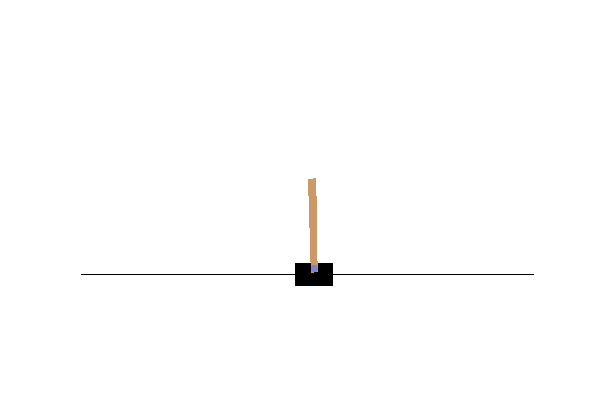
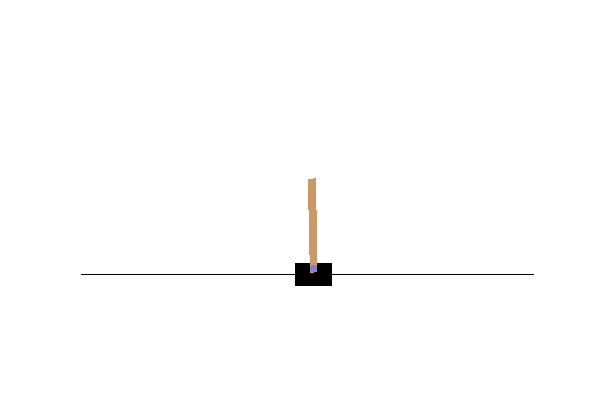
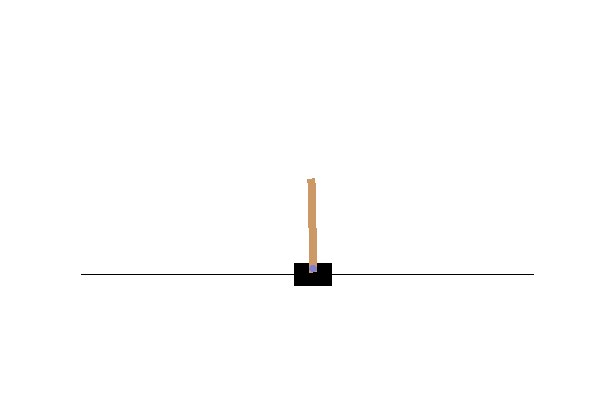
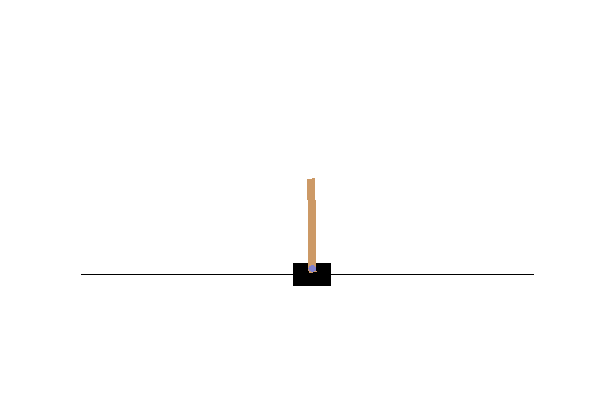
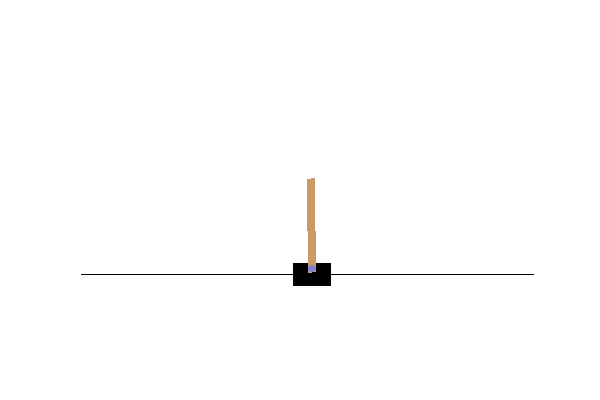
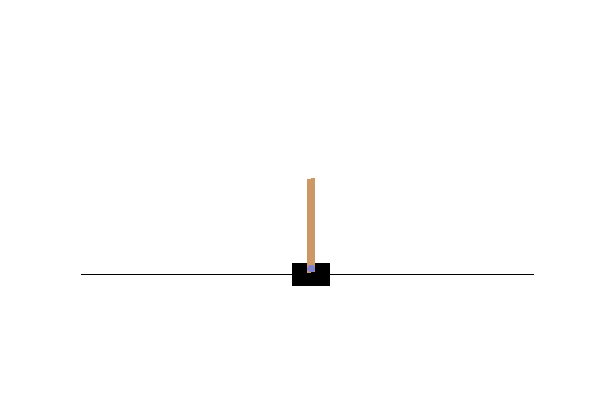
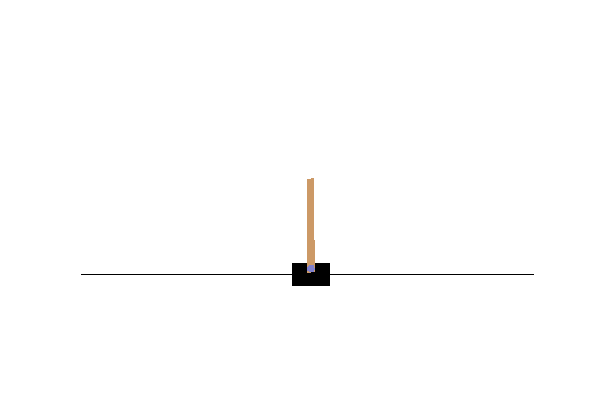
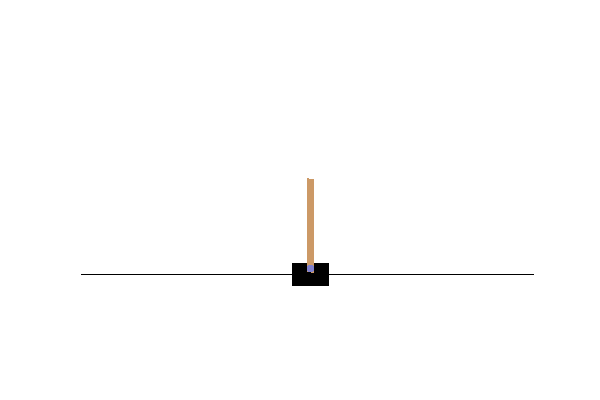
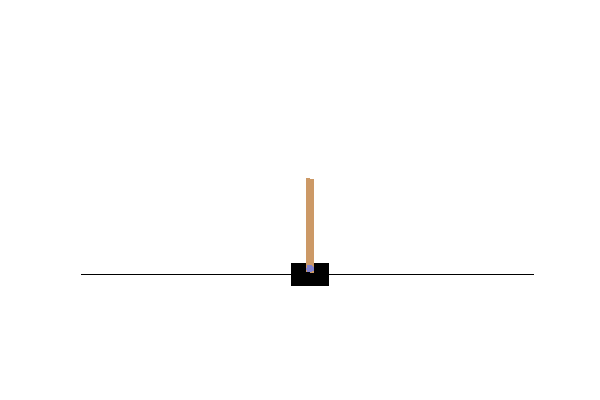
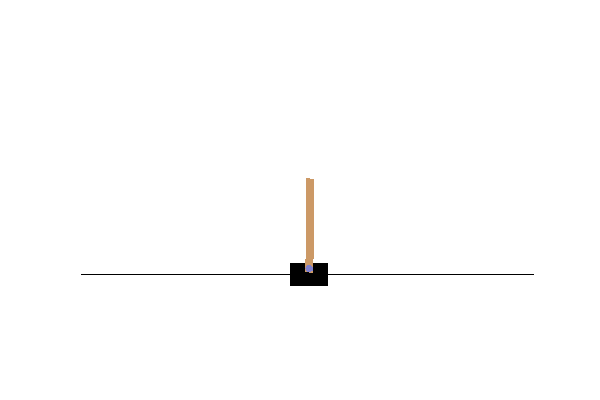
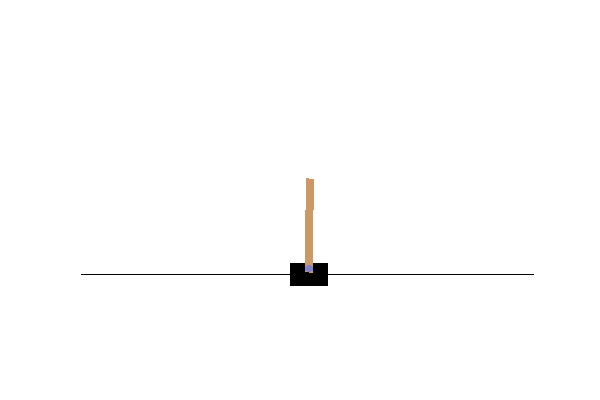
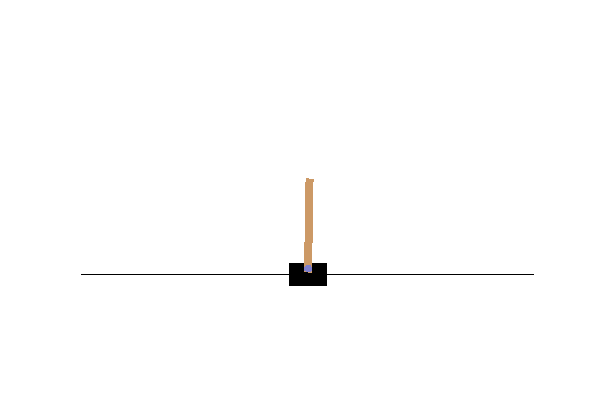
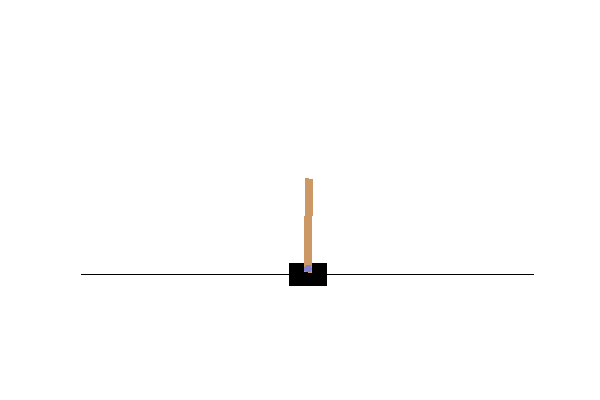
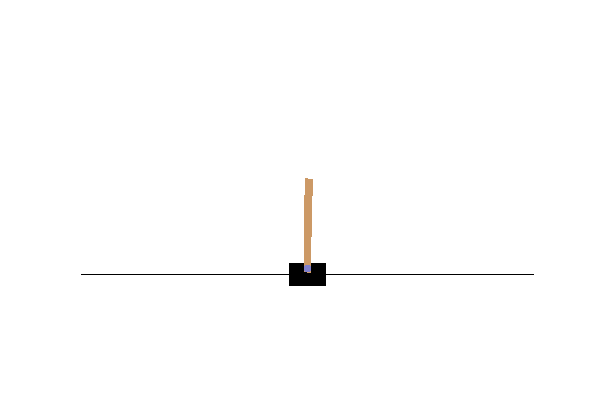
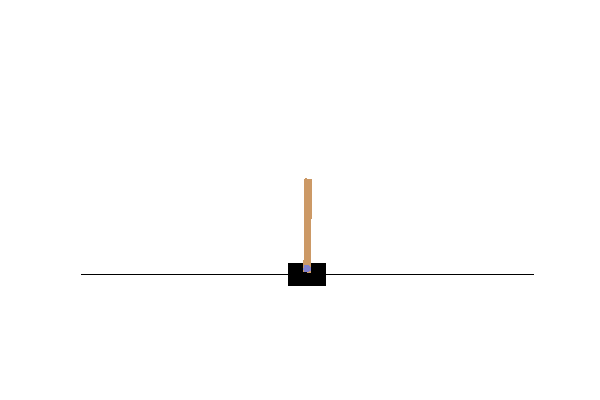
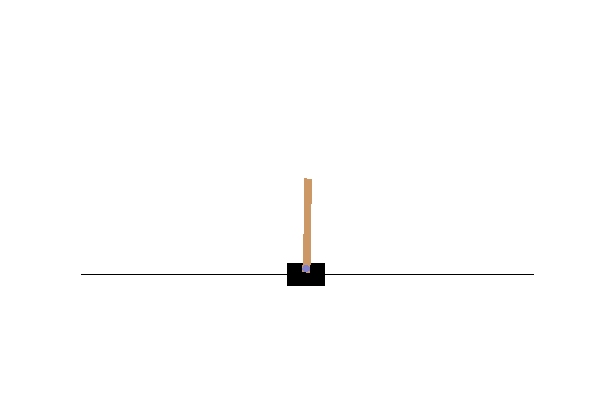
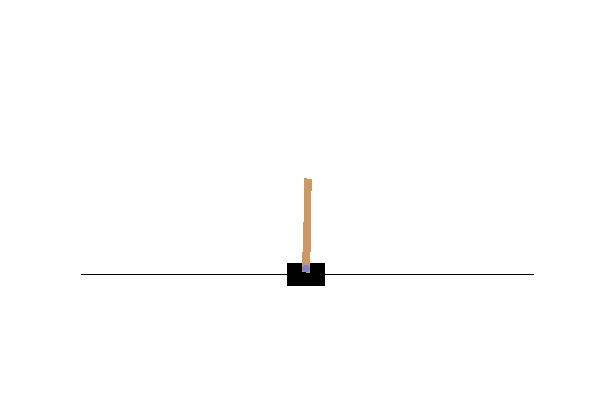
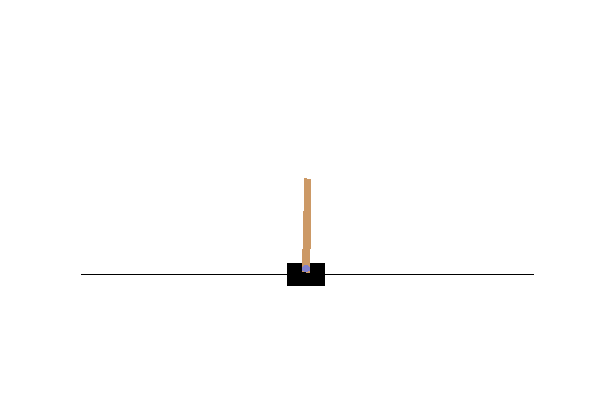
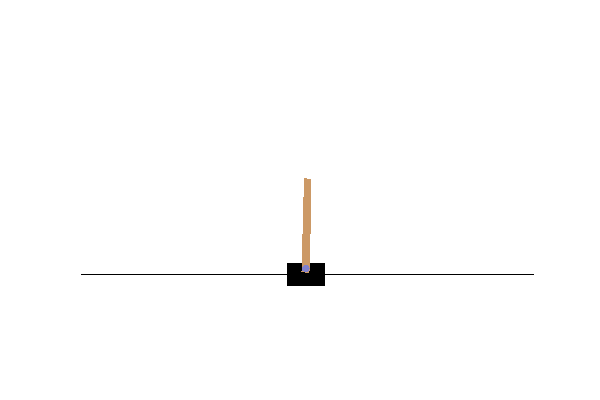
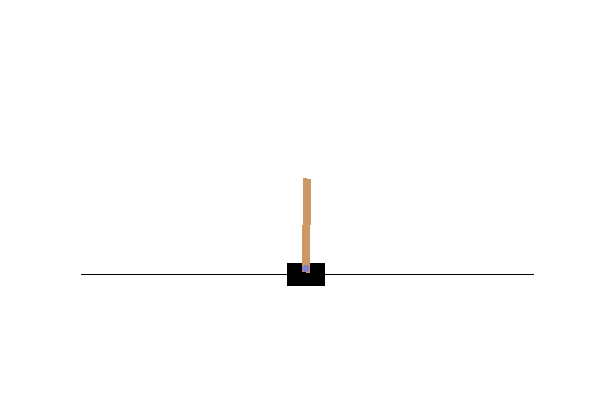
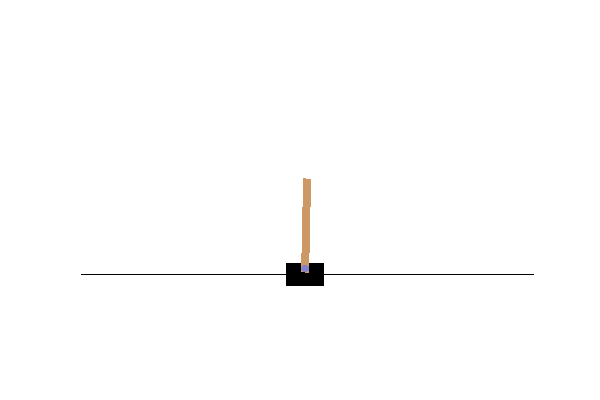
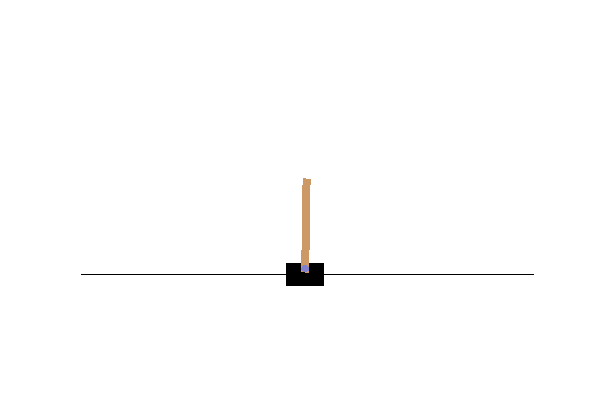
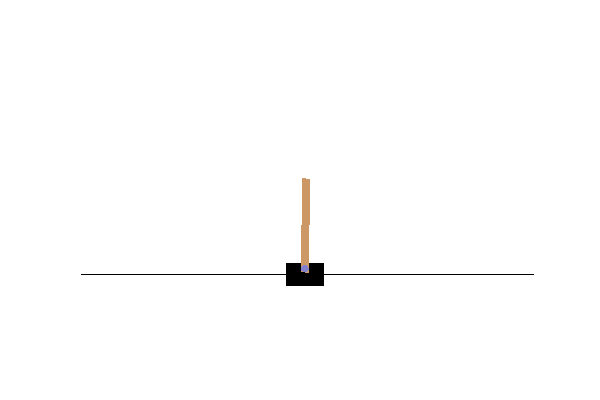
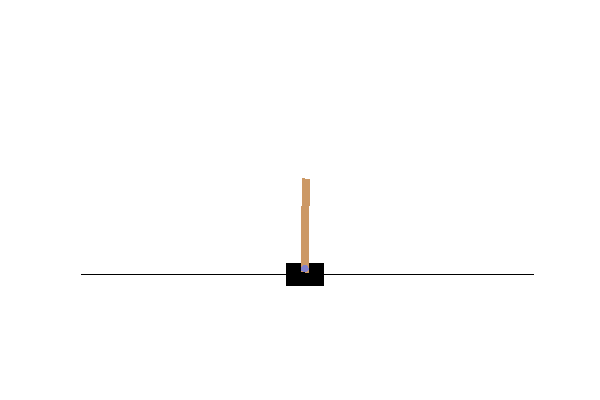
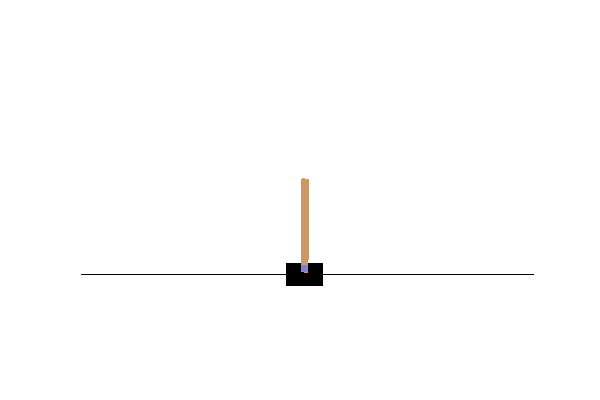
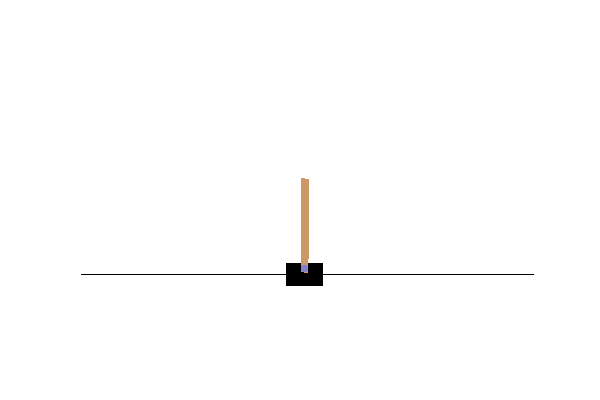
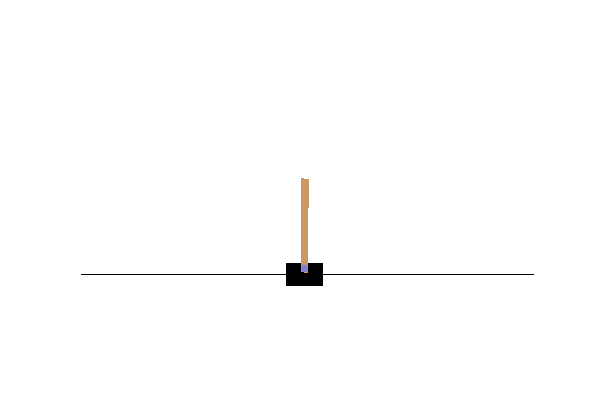
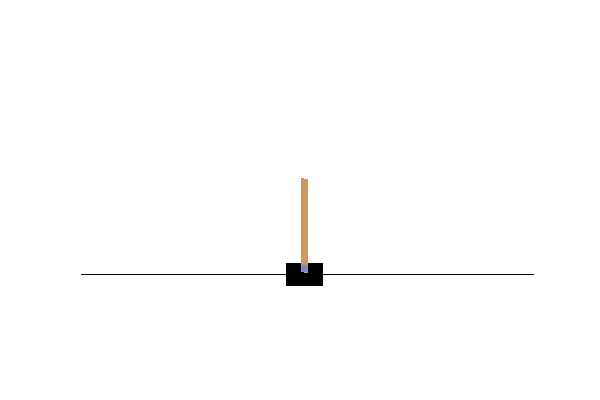
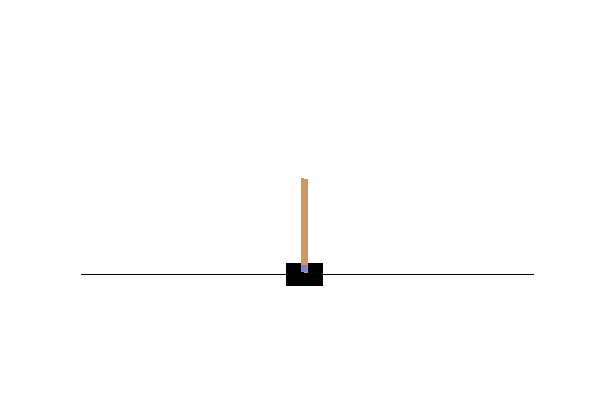
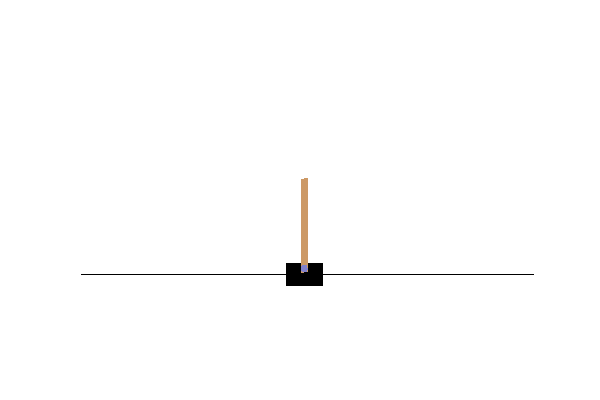
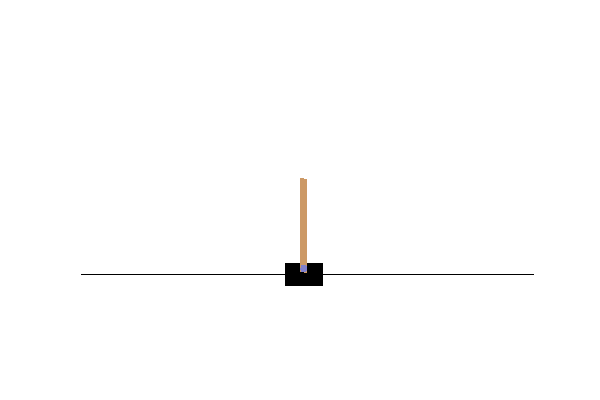
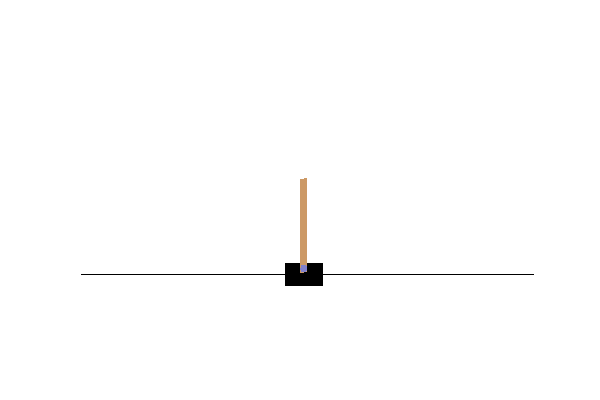
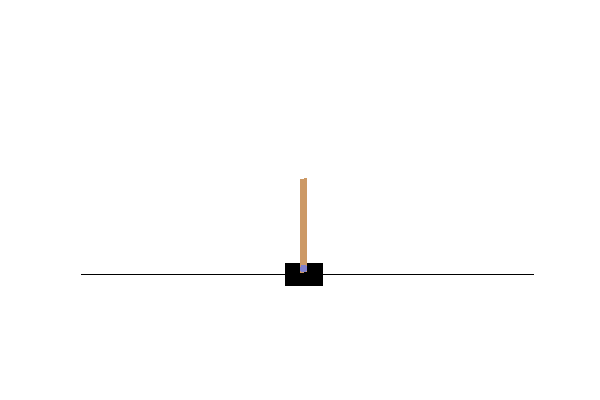
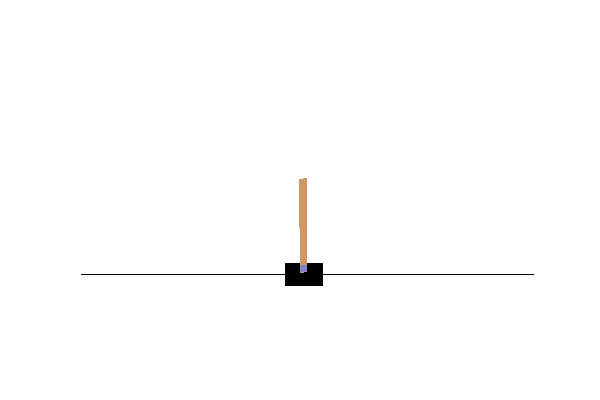
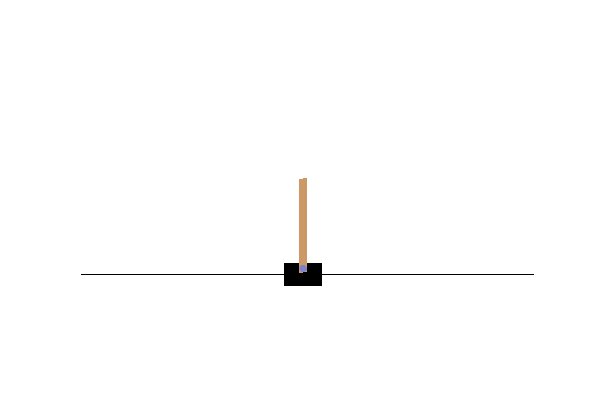
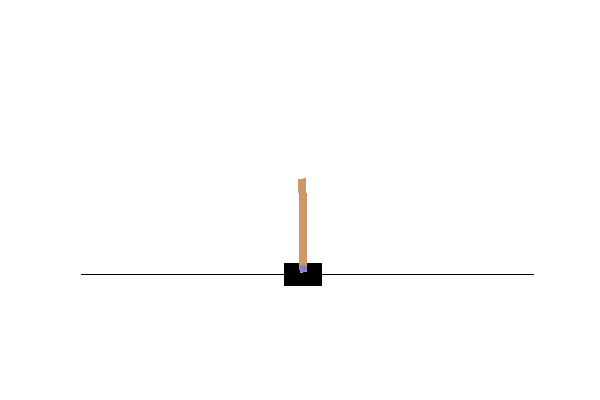
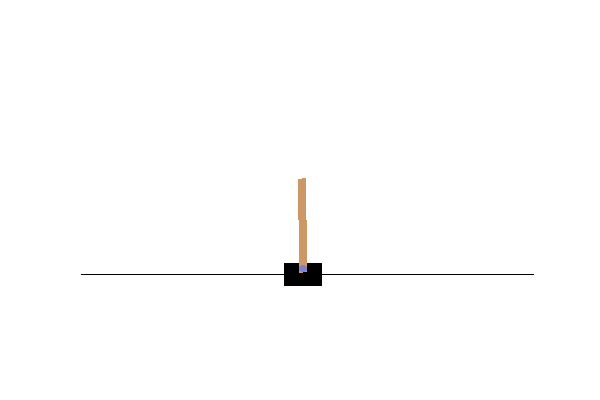
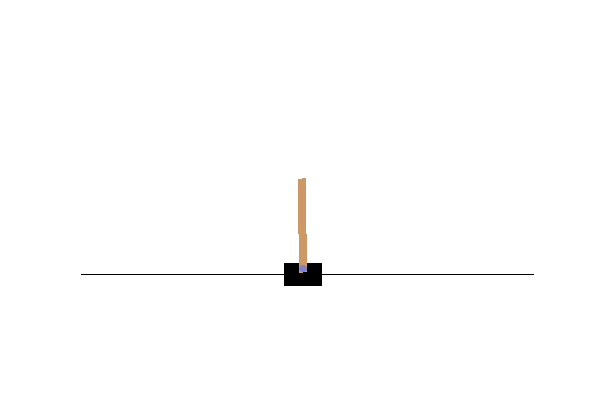
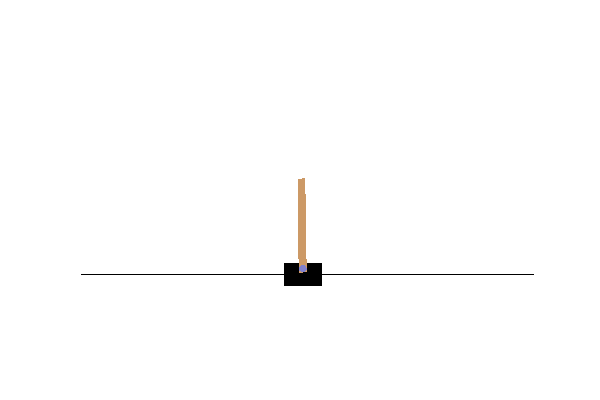
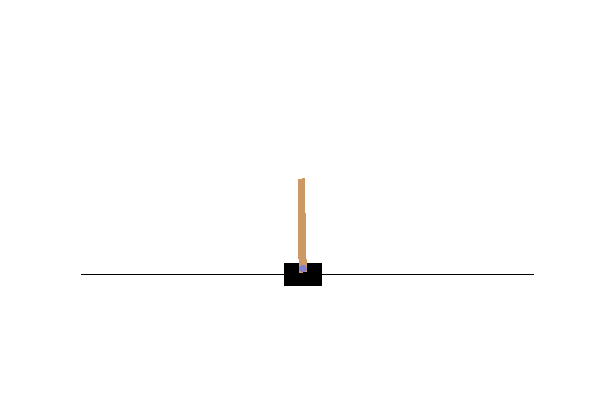
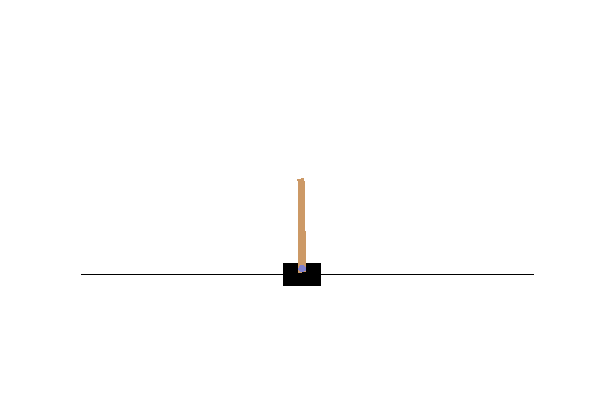
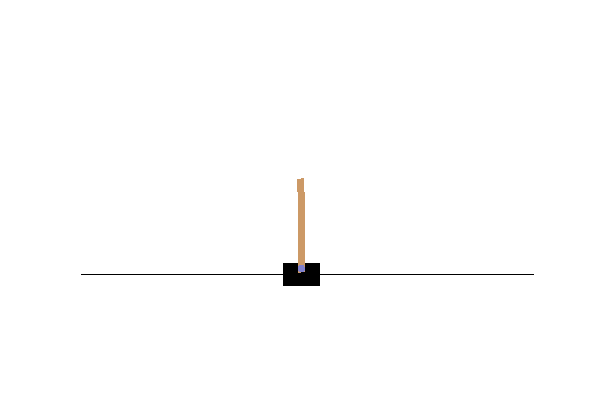
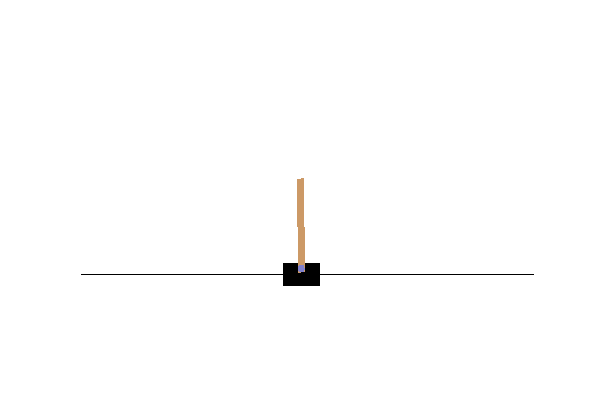
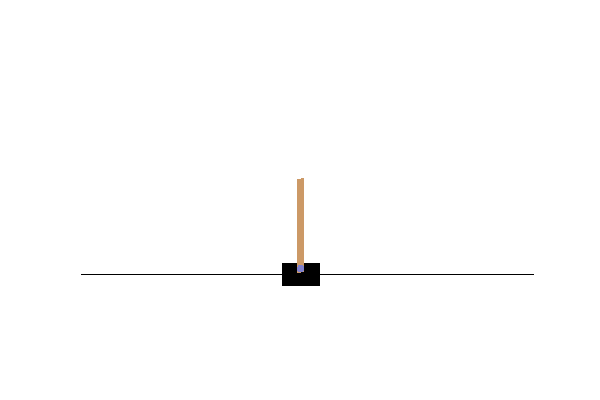
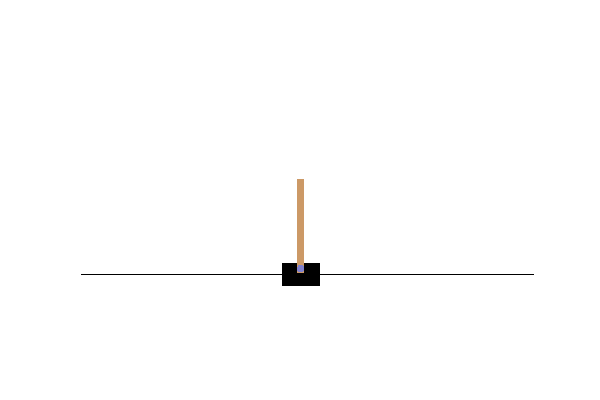
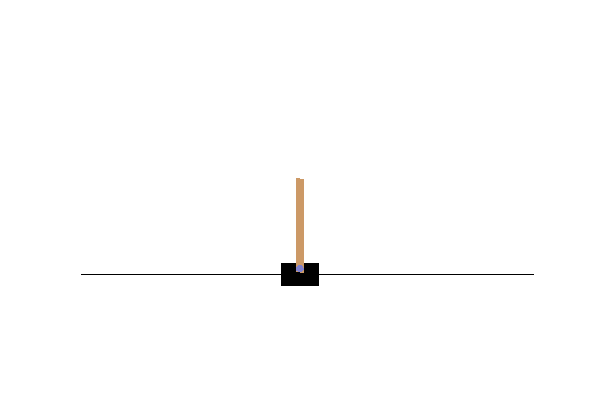
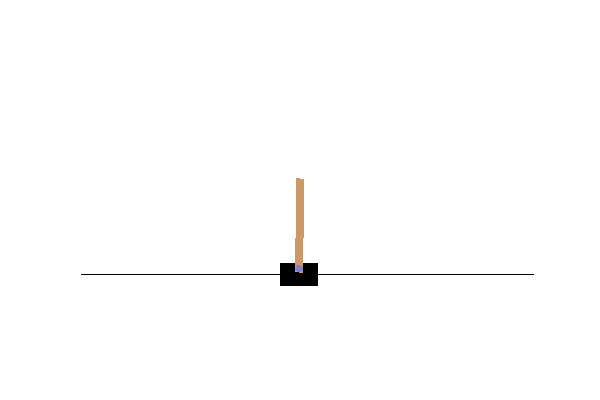
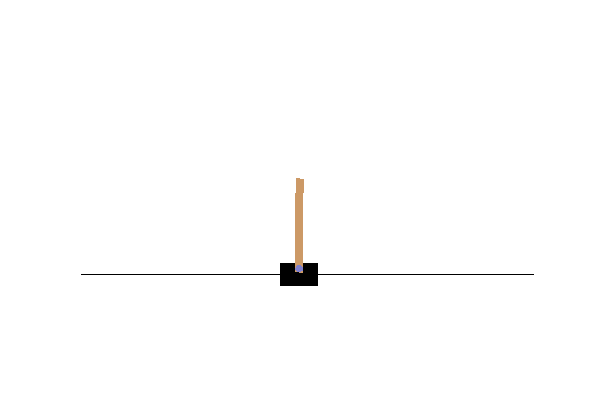
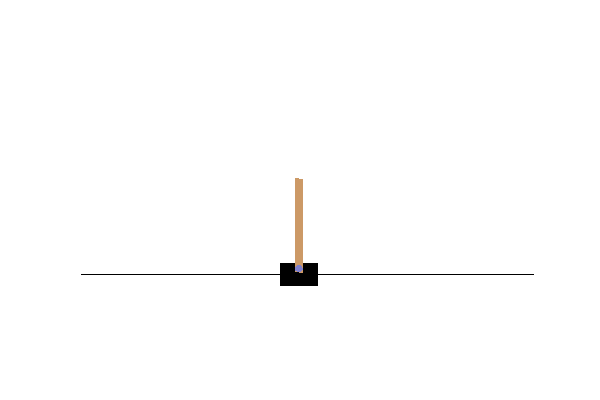
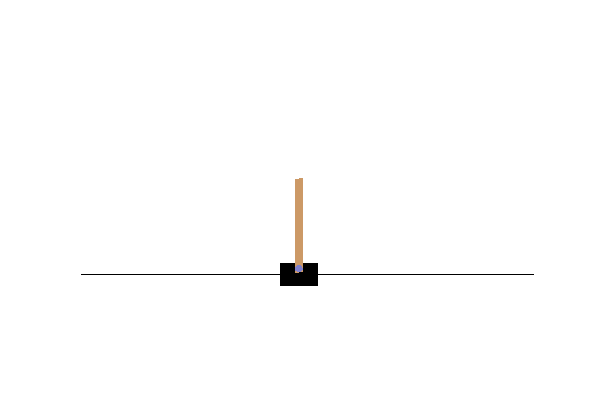
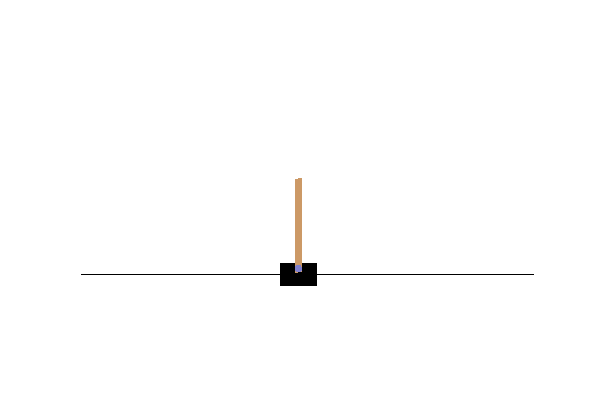
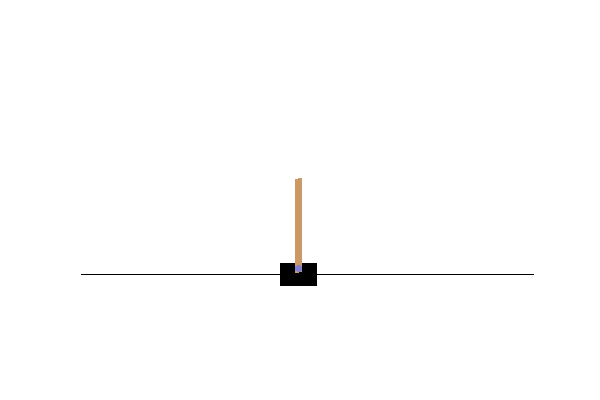
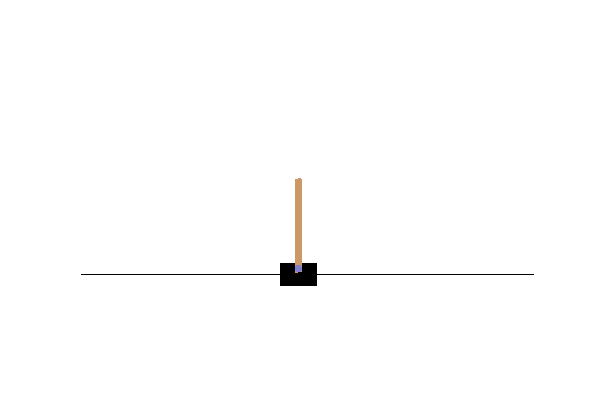
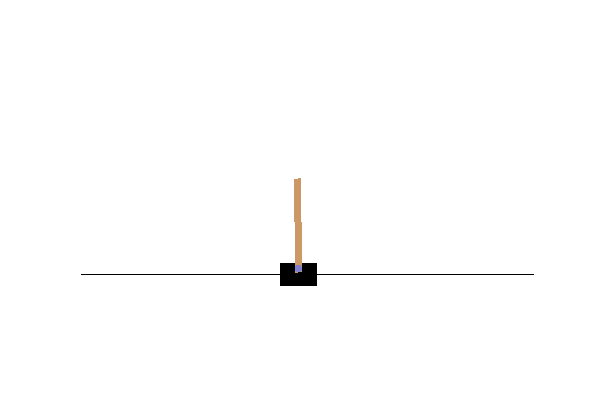
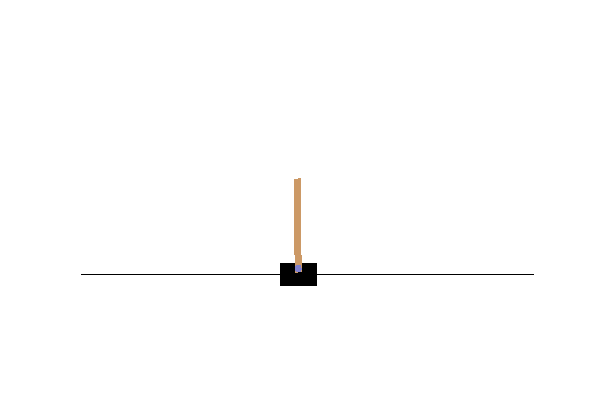
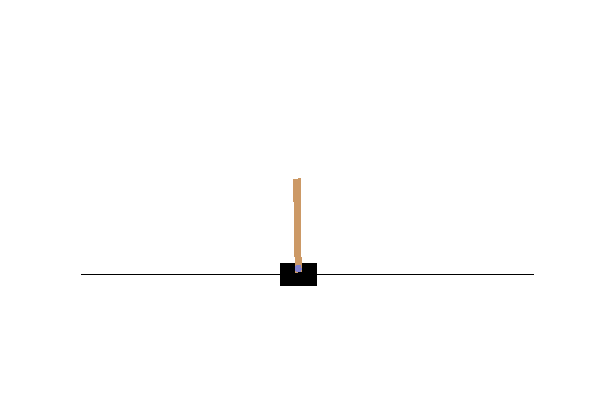
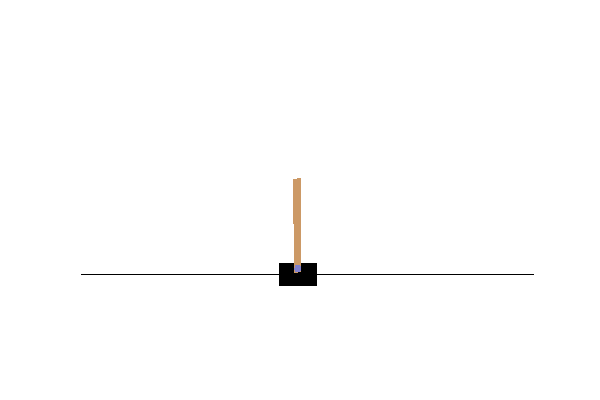
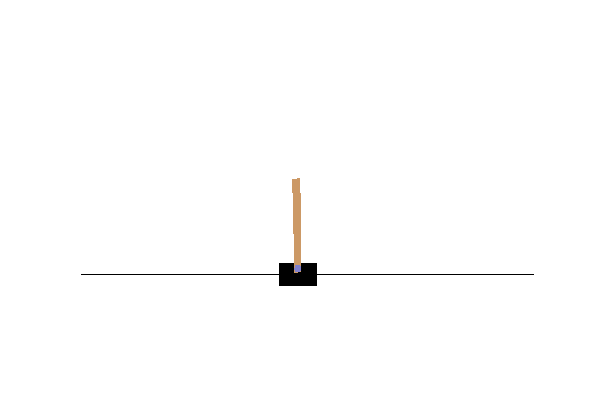
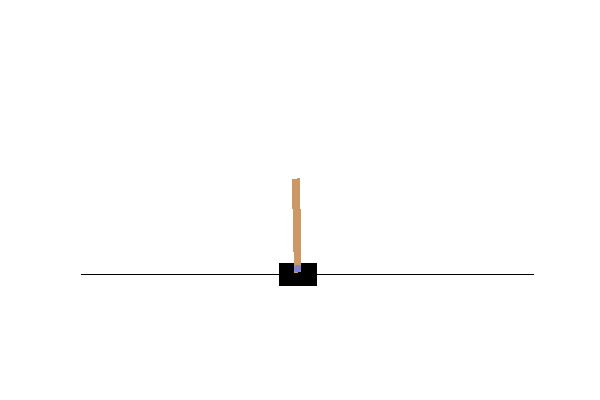
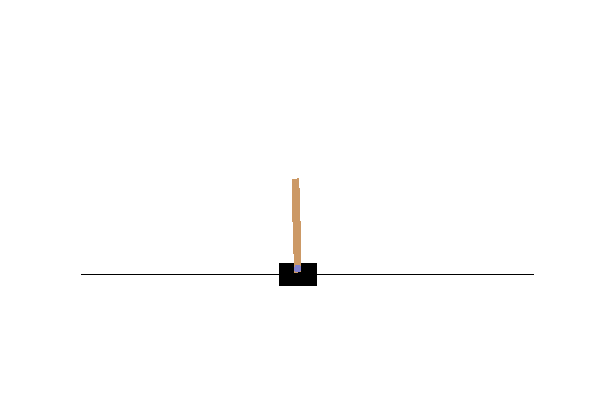
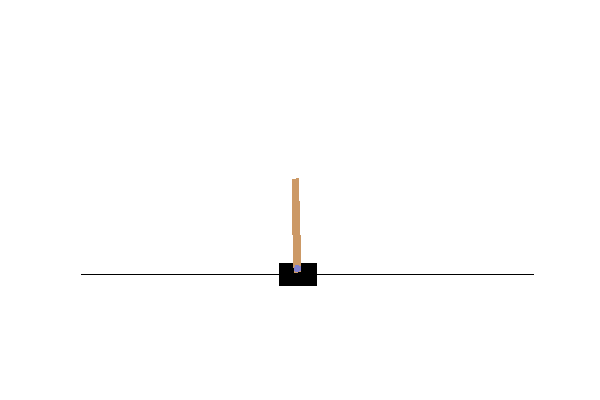
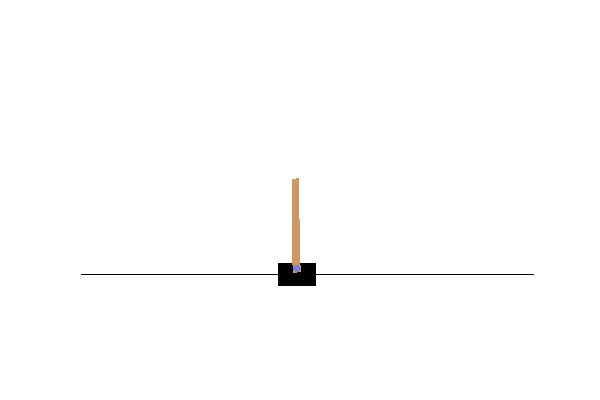
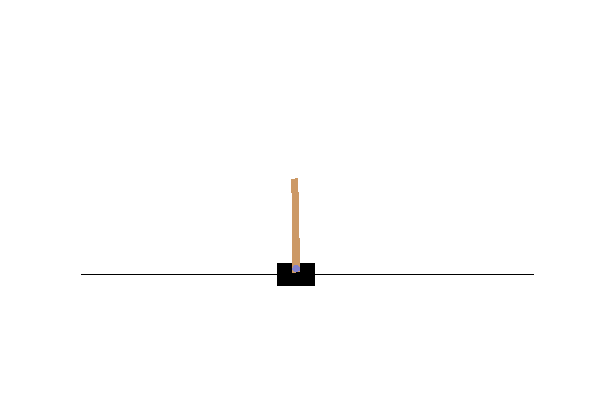
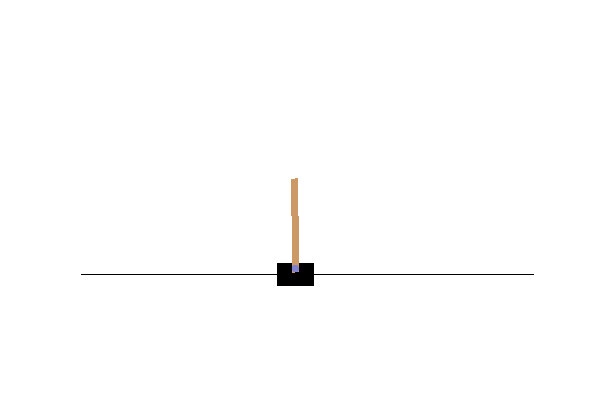
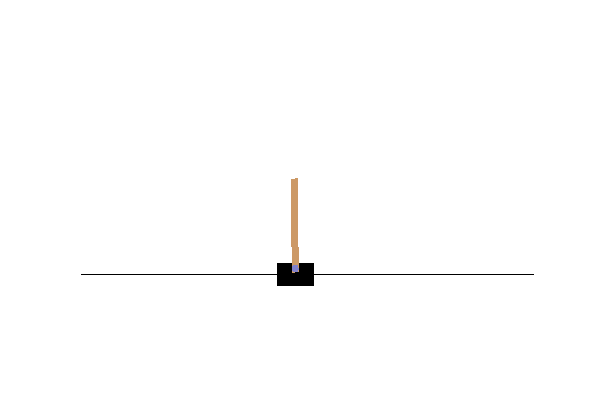
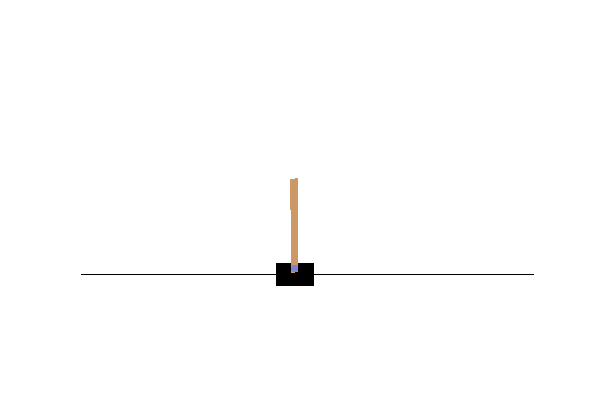
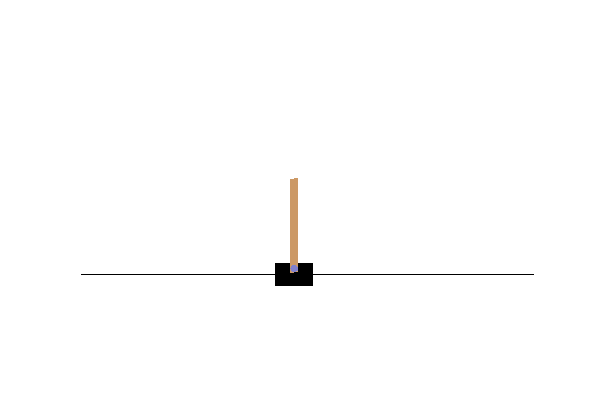
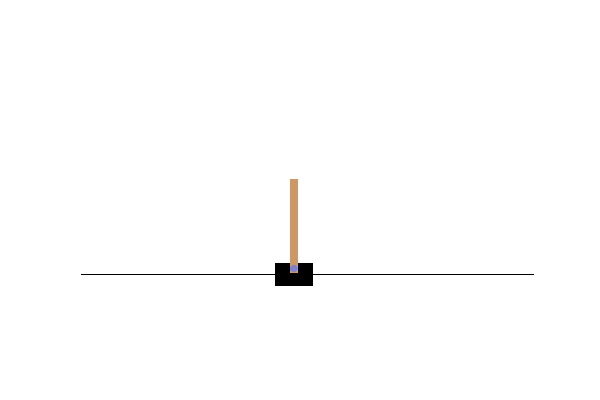
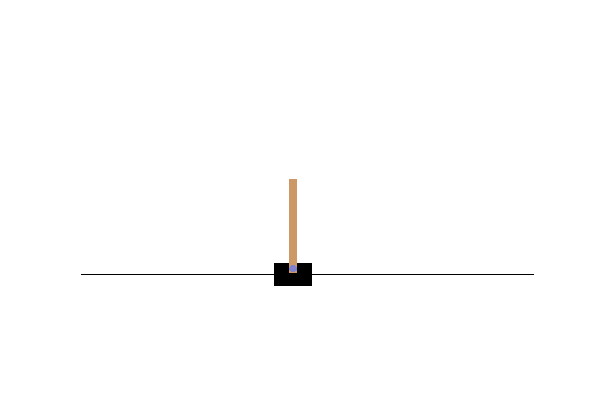
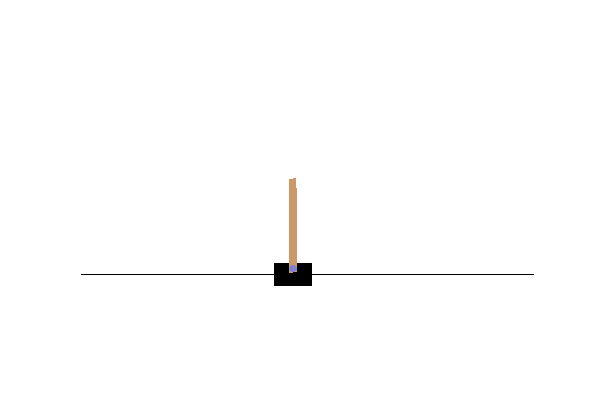
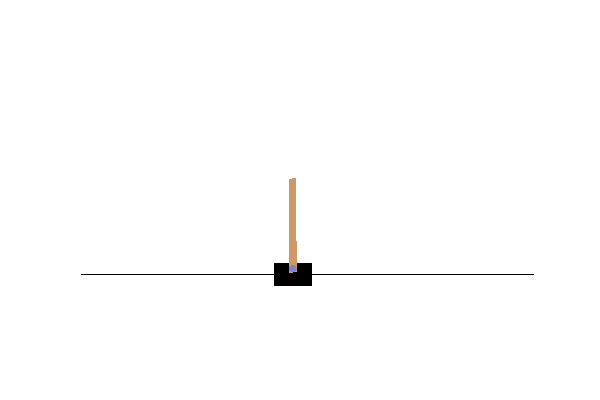
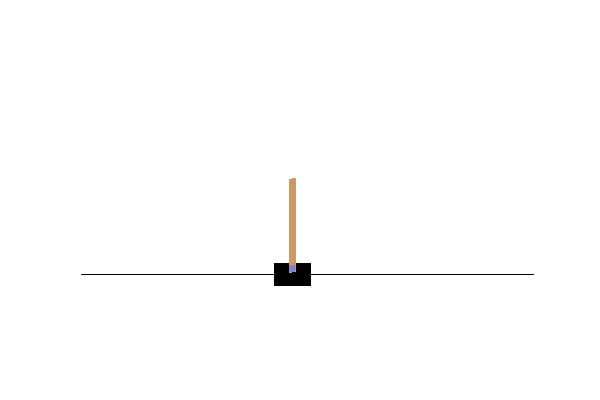
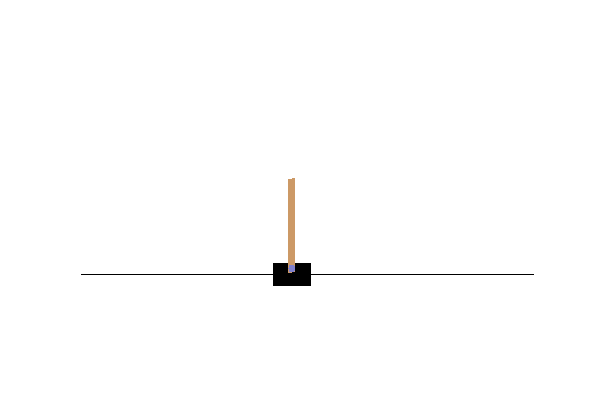
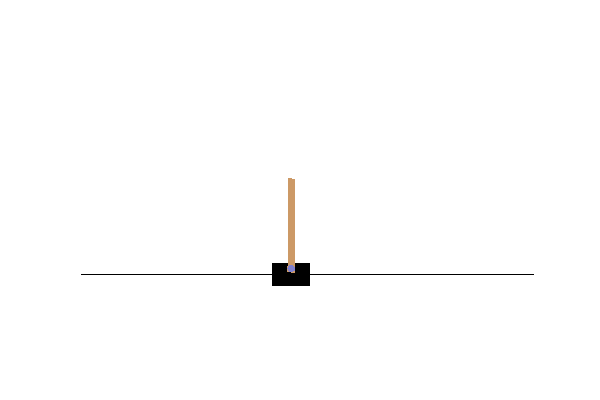
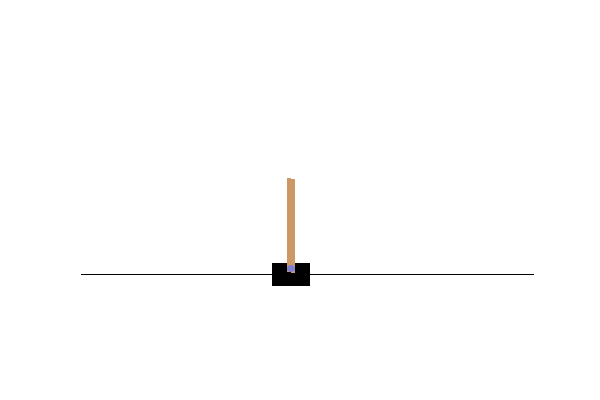
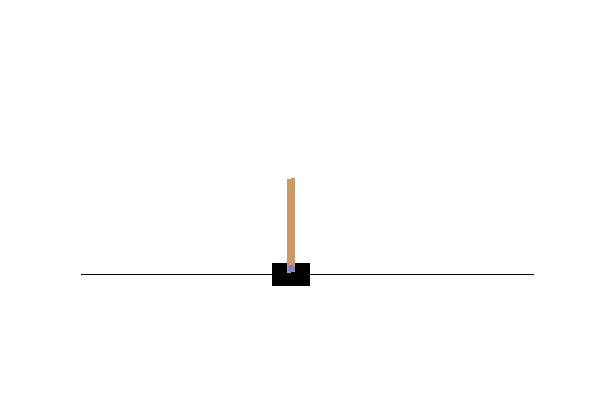
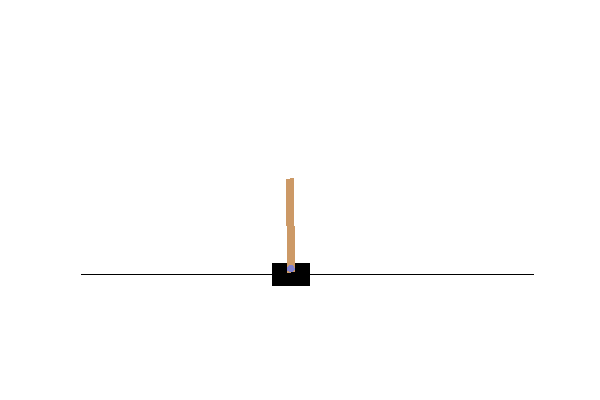
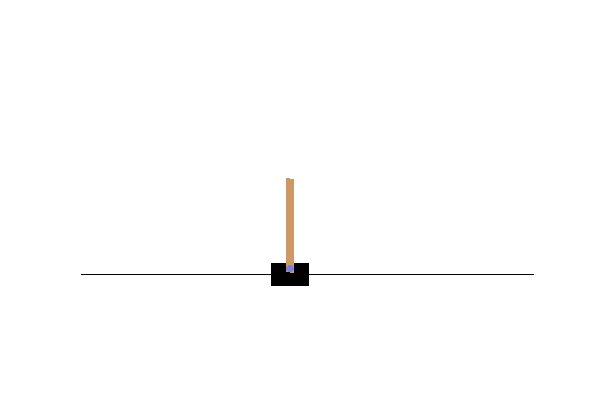
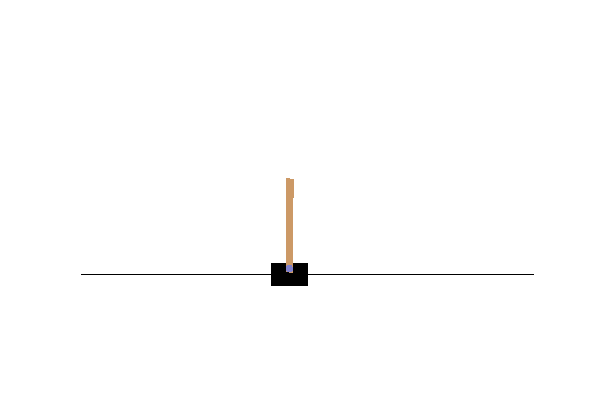
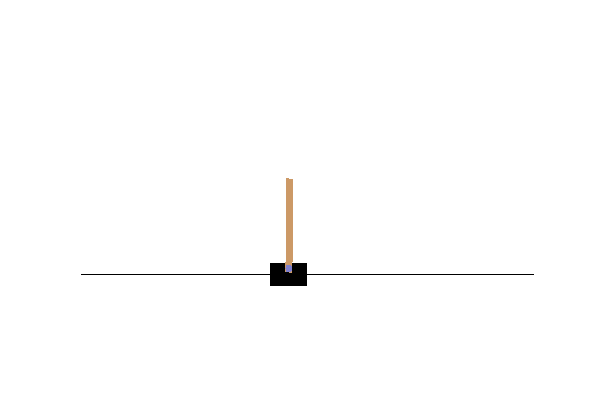
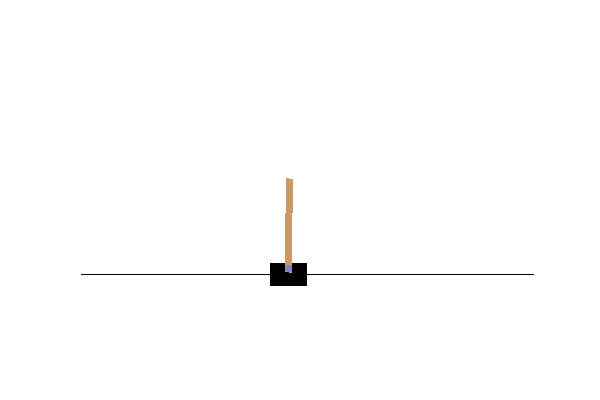
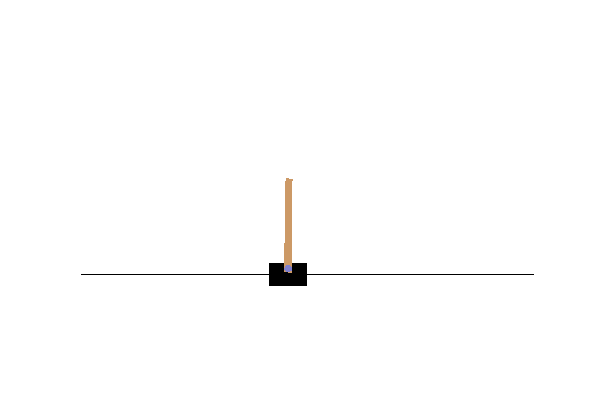
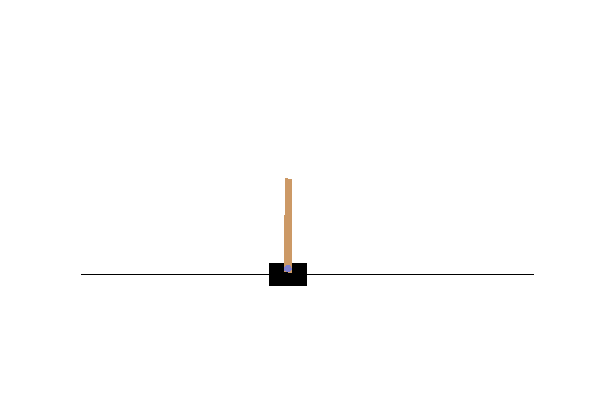
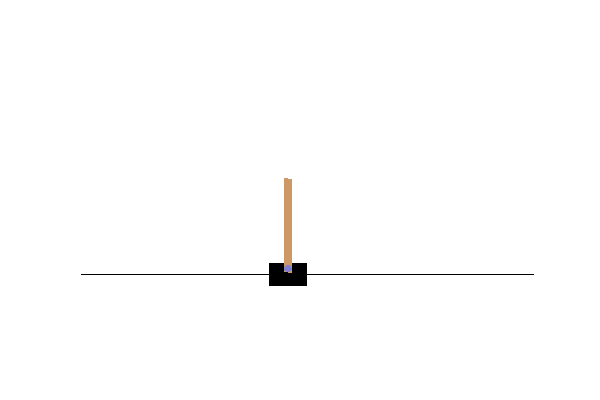
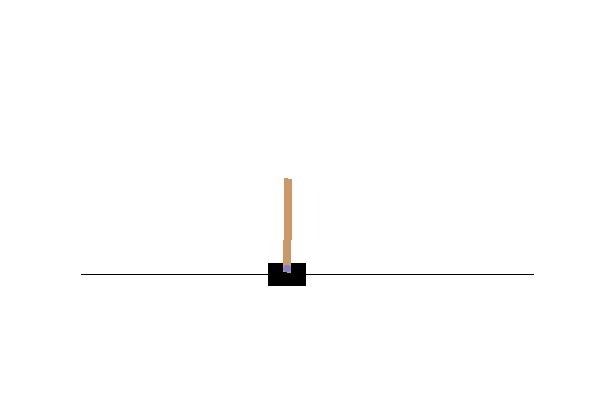
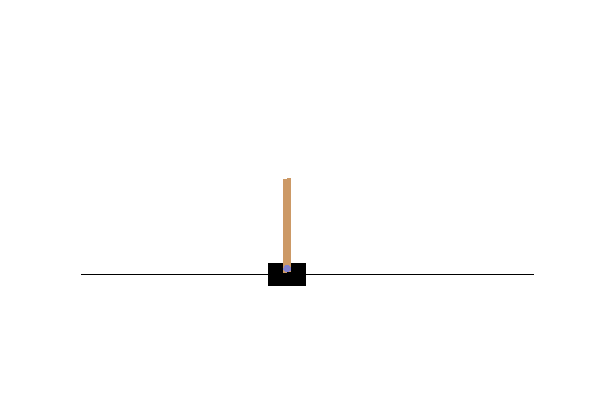
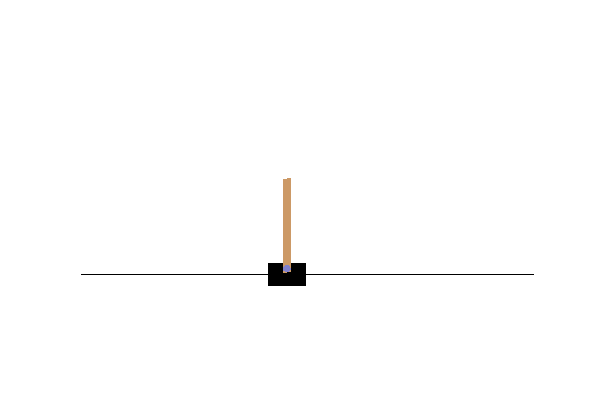
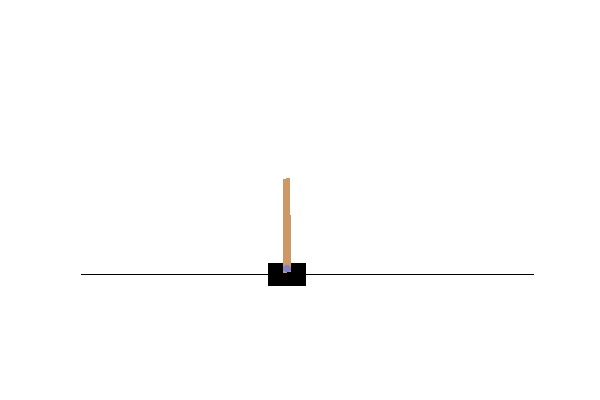
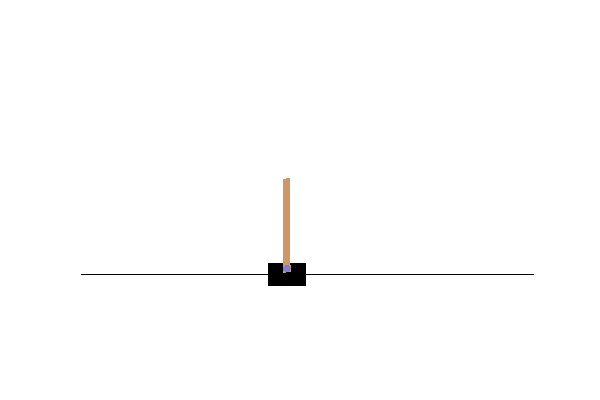
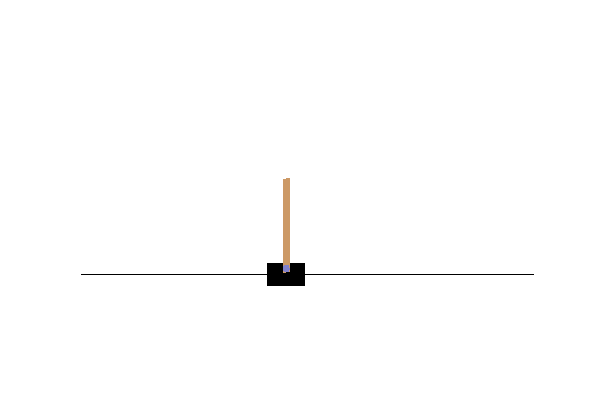
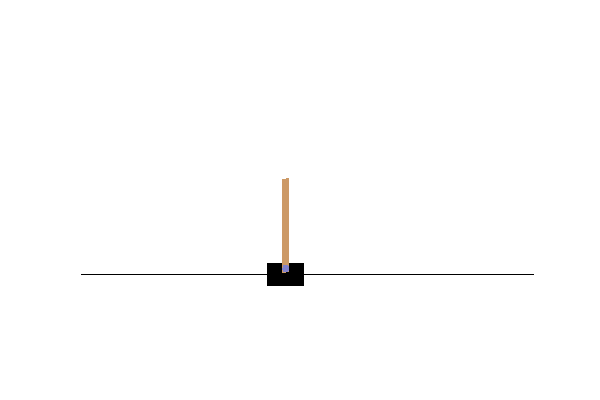
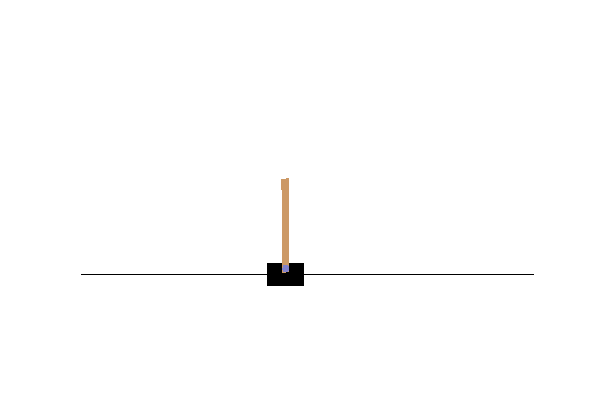
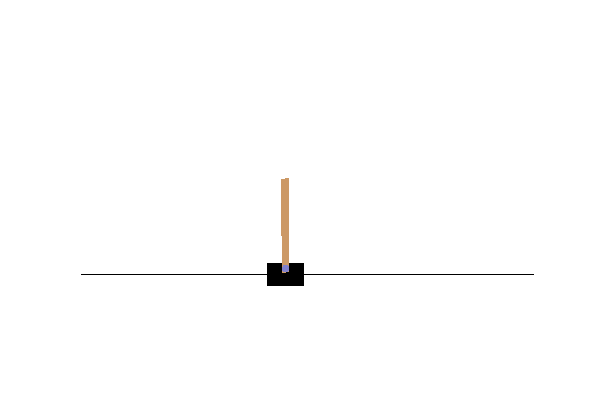
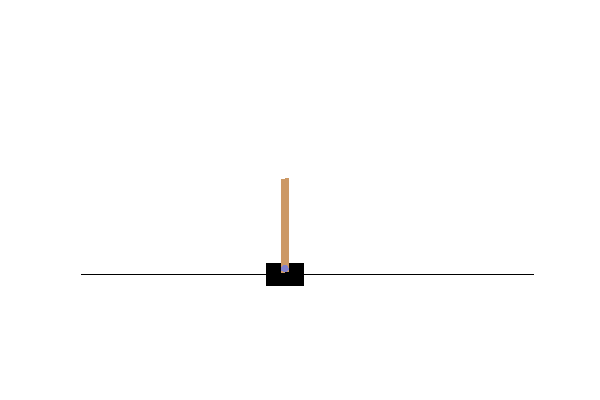
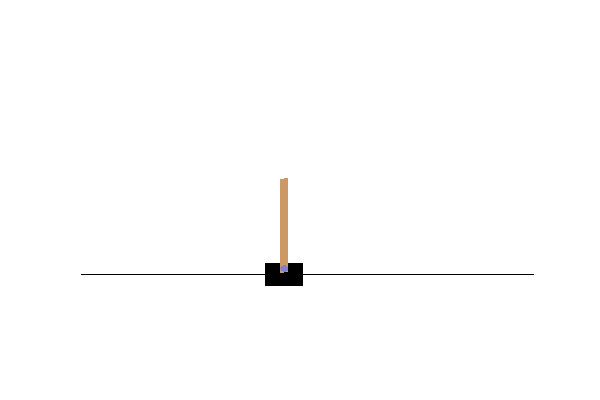
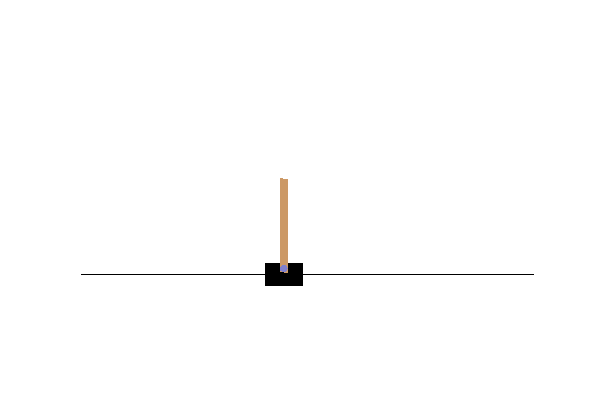
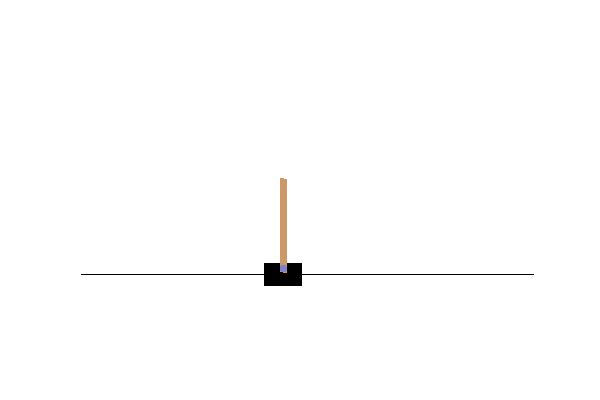
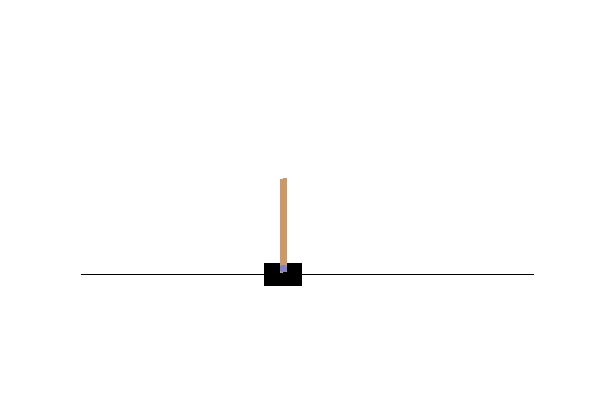
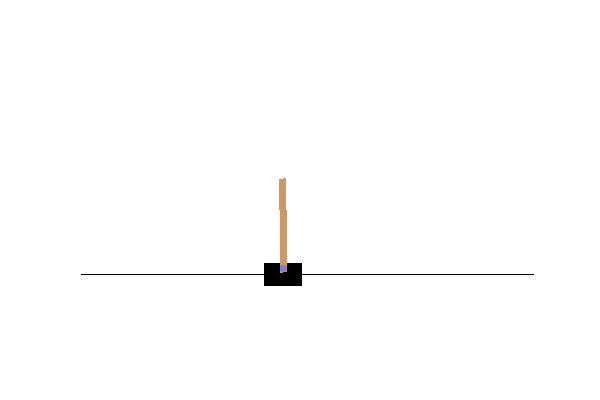
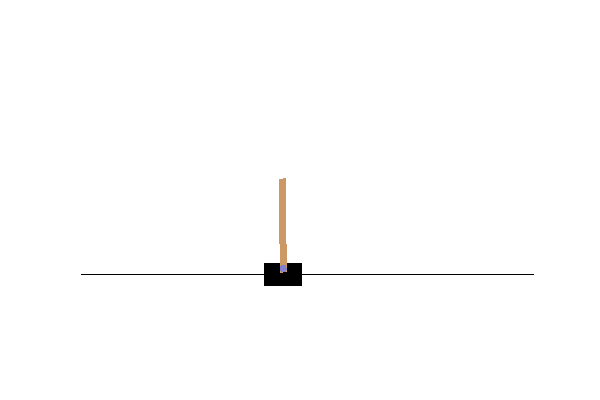
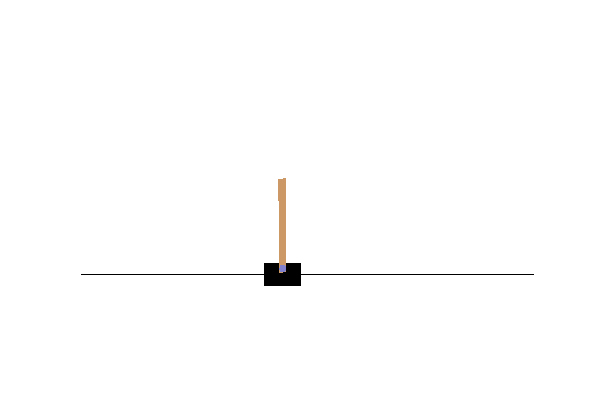
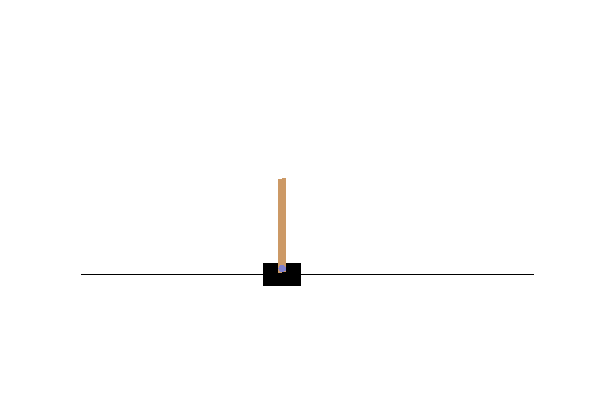
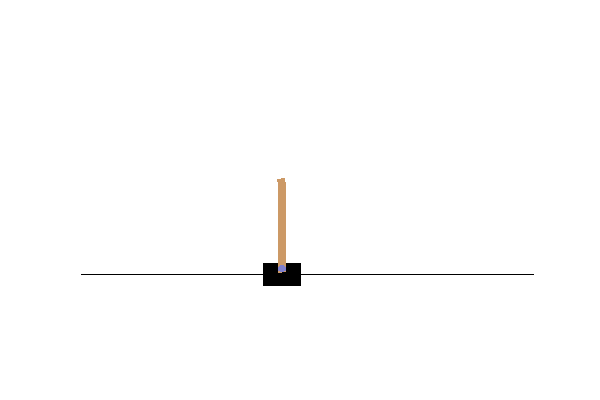
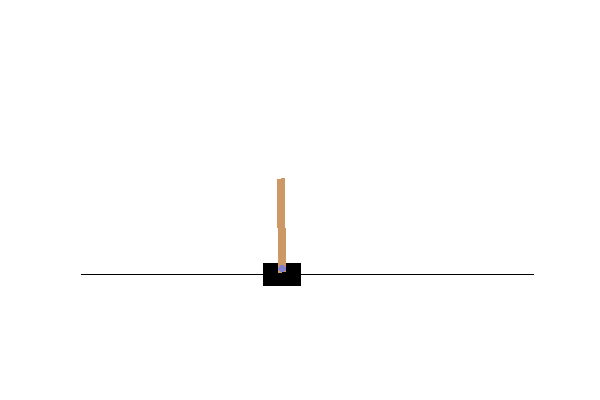
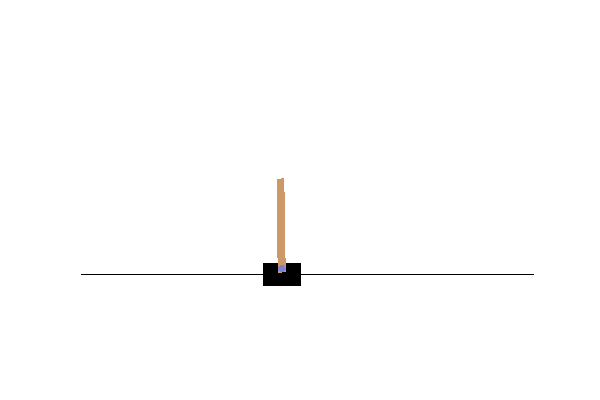
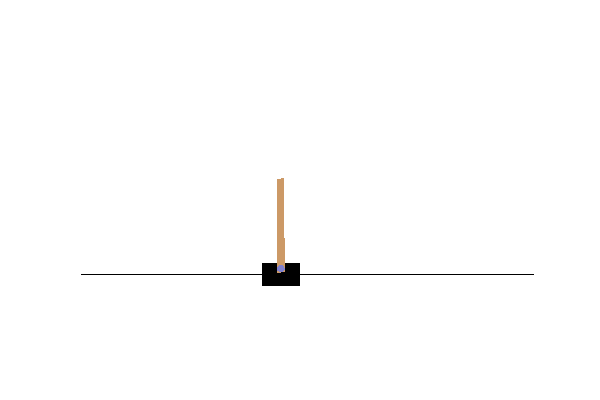
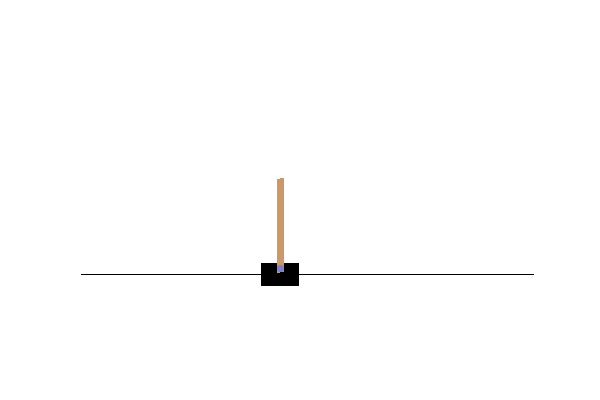
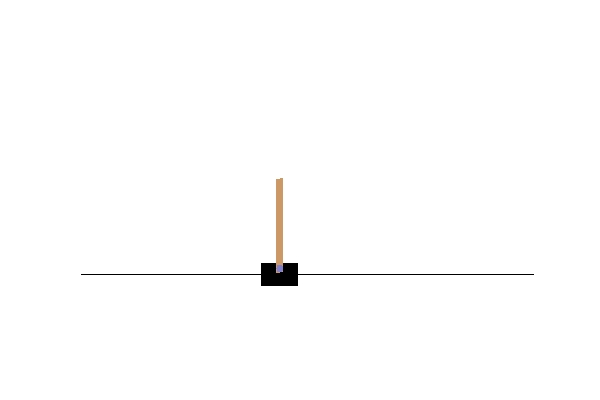
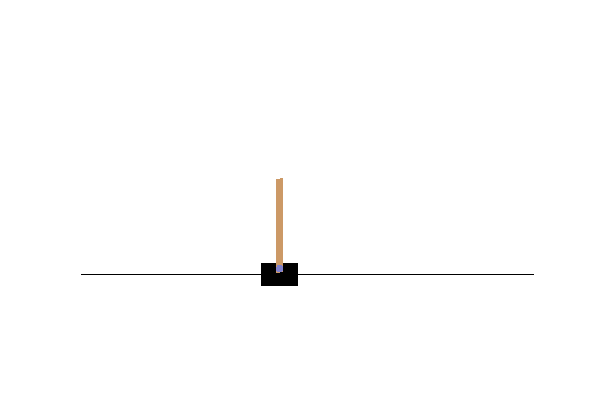
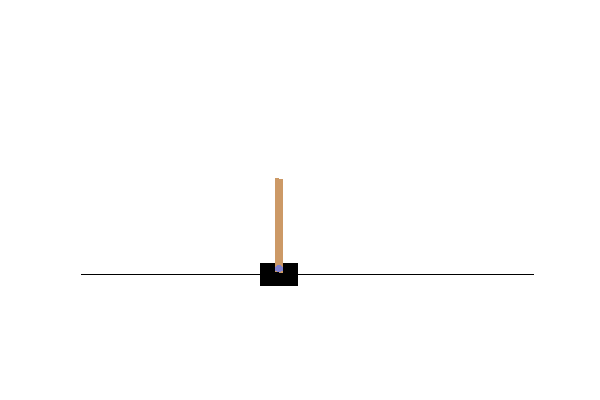
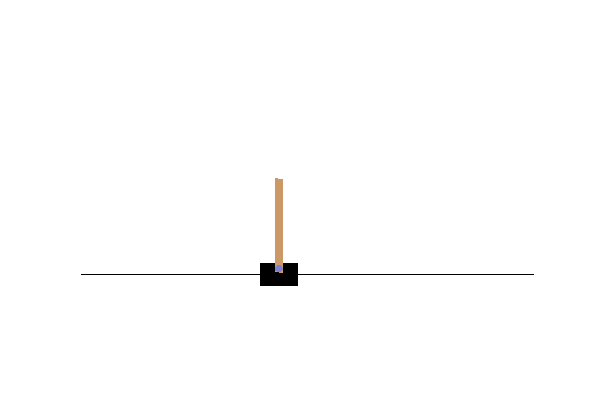
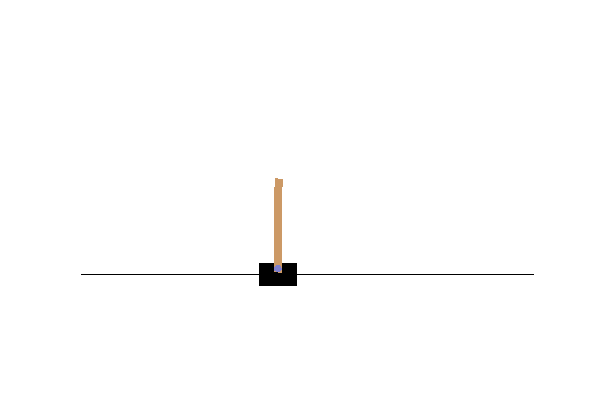
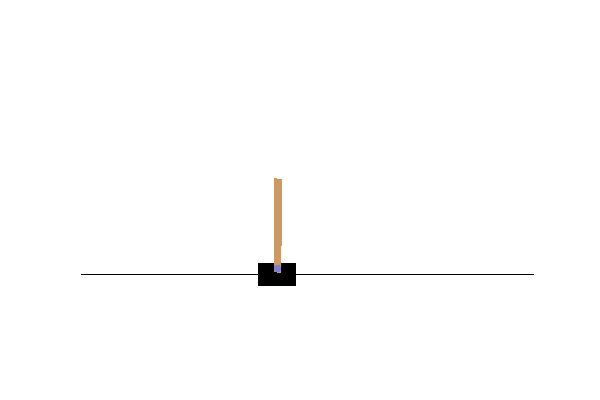
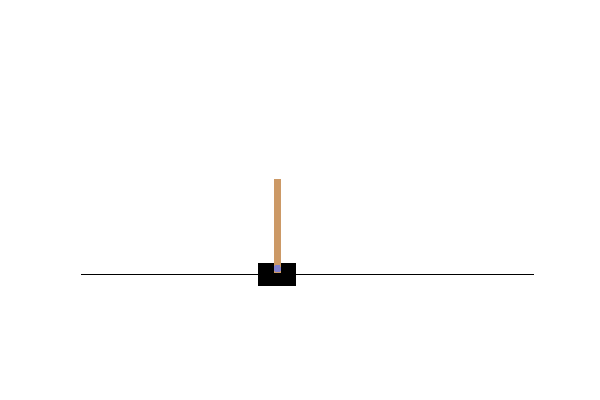
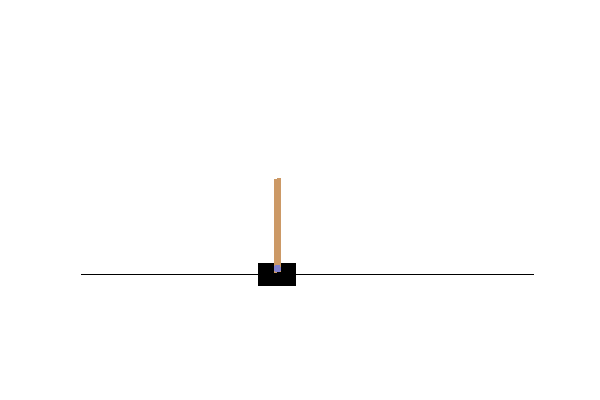
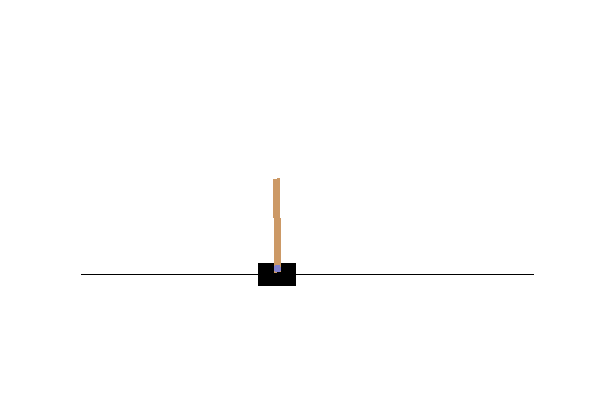

In [14]:
cartpole_env = Environment()
cartpole_env.run()